In [1]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import pandas as pd
import netCDF4
import properscoring as ps
import pickle

import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, FixedLocator
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.animation as animation

import seaborn as sns
import calendar


from gp_mjo.models.empgp_mjo_model import EmpGPMJO
from gp_mjo.models.empgp_mjo_pred import EmpGPMJOPred
from gp_mjo.models.nn_models import FFNNModel

# Data

## MJO from S2S

In [2]:
# Path to the folder containing .nc files
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, '..'))
dir_names = ["ecmwf", "bom", "cnrm", "ecmwf_txt"] #["ecmwf", "ecmwf_txt", "bom", "cnrm"]

s2s_data = {}
for dir_name in dir_names:
    folder_path = os.path.join(parent_dir, "data", dir_name)

    if dir_name == 'ecmwf_txt':
        load_path = os.path.join(folder_path, 'ecmwf_dict.pkl')
        with open(load_path, 'rb') as f:
            loaded_dict = pickle.load(f)
        s2s_data['ecmwf_txt'] = loaded_dict
    else:

        # Get a list of all .nc files in the folder
        nc_files_path = [f for f in os.listdir(folder_path) if f.endswith('.nc')]

        data_arrays = {}
        for nc_file in nc_files_path:
            file_path = os.path.join(folder_path, nc_file)
            
            # Open the NetCDF file
            dataset = netCDF4.Dataset(file_path, 'r')
            
            file_data = {}
            # Loop through all variables in the dataset
            for var_name in dataset.variables.keys():
                data_array = np.array(dataset.variables[var_name][:]) # Read the data and convert it to a numpy array
                if var_name == 'S':
                    data_array -= 6940 # 1979-01-01 - 1960-01-01 = 6940 days
                if var_name == 'hdate':
                    data_array -= 228 # 1979-01-01 - 1960-01-01 = 228 months
                if var_name in ['S', 'L', 'M', 'hdate']: # convert to integer
                    data_array = data_array.astype(int)
                file_data[var_name] = data_array # Store the data array in the file's dictionary

            data_arrays[nc_file] = file_data    
            dataset.close()

        s2s_data[dir_name] = data_arrays

        # remove NaN
        if dir_name == 'ecmwf':
            remove_ids = np.argwhere( np.isnan( s2s_data[dir_name]['ensemble_mean_rmm1.nc']['RMM1'][9][:, 0] ) ).squeeze() #'hdate' = 9, 10,...,1, set lead_time=0
            s_axis = 1
        elif dir_name in ['bom', 'cnrm']:
            remove_ids = np.argwhere( np.isnan( s2s_data[dir_name]['ensemble_mean_rmm1.nc']['RMM1'][:, 0] ) ).squeeze()
            s_axis = 0
        
        s2s_data[dir_name]['ensemble_mean_rmm1.nc']['RMM1'] = np.delete(s2s_data[dir_name]['ensemble_mean_rmm1.nc']['RMM1'], obj=remove_ids, axis=s_axis)
        s2s_data[dir_name]['ensemble_mean_rmm2.nc']['RMM2'] = np.delete(s2s_data[dir_name]['ensemble_mean_rmm2.nc']['RMM2'], obj=remove_ids, axis=s_axis)
        
        s2s_data[dir_name]['ensembles_rmm1.nc']['RMM1'] = np.delete(s2s_data[dir_name]['ensembles_rmm1.nc']['RMM1'], obj=remove_ids, axis=s_axis)
        s2s_data[dir_name]['ensembles_rmm2.nc']['RMM2'] = np.delete(s2s_data[dir_name]['ensembles_rmm2.nc']['RMM2'], obj=remove_ids, axis=s_axis)

        for nc_file in nc_files_path:
            s2s_data[dir_name][nc_file]['S'] = np.delete(s2s_data[dir_name][nc_file]['S'], obj=remove_ids, axis=0)


# Now `data_arrays` dictionary contains numpy arrays for each .nc file
for dir_name, variables in s2s_data.items():
    print(f"{dir_name}: {variables.keys()}")



# Example: Accessing the data from a specific file
example_dir_name =  'ecmwf' # ['bom', 'cnrm', 'ecmwf']

example_dir = s2s_data[example_dir_name]
if example_dir_name == 'ecmwf_txt':
    filenames = ['ensemble_mean', 'ensembles']
else:
    filenames = ['ensemble_mean_rmm1.nc', 'ensemble_mean_rmm2.nc', 'ensembles_rmm1.nc', 'ensembles_rmm2.nc']

for filename in filenames:
    variables = list(example_dir[filename].keys())

    for variable in variables:
        example_data = example_dir[filename][variable]
        print(f"Data from {filename}, Variable: {variable}, Shape: {example_data.shape}")

ecmwf: dict_keys(['ensembles_rmm2.nc', 'ensemble_mean_rmm1.nc', 'ensemble_mean_rmm2.nc', 'ensembles_rmm1.nc'])
bom: dict_keys(['ensembles_rmm2.nc', 'ensemble_mean_rmm1.nc', 'ensemble_mean_rmm2.nc', 'ensembles_rmm1.nc'])
cnrm: dict_keys(['ensembles_rmm2.nc', 'ensemble_mean_rmm1.nc', 'ensemble_mean_rmm2.nc', 'ensembles_rmm1.nc'])
ecmwf_txt: dict_keys(['ensemble_mean', 'ensembles'])
Data from ensemble_mean_rmm1.nc, Variable: hdate, Shape: (29,)
Data from ensemble_mean_rmm1.nc, Variable: S, Shape: (920,)
Data from ensemble_mean_rmm1.nc, Variable: L, Shape: (46,)
Data from ensemble_mean_rmm1.nc, Variable: RMM1, Shape: (29, 920, 46)
Data from ensemble_mean_rmm2.nc, Variable: L, Shape: (46,)
Data from ensemble_mean_rmm2.nc, Variable: hdate, Shape: (29,)
Data from ensemble_mean_rmm2.nc, Variable: S, Shape: (920,)
Data from ensemble_mean_rmm2.nc, Variable: RMM2, Shape: (29, 920, 46)
Data from ensembles_rmm1.nc, Variable: L, Shape: (46,)
Data from ensembles_rmm1.nc, Variable: S, Shape: (920,)
Da

## MJO from CAWCR (http://www.bom.gov.au/climate/mjo/)

In [3]:
npzfile = np.load('../data/obs/mjo_new_data.npz', allow_pickle=True)
print(npzfile.files)
print(npzfile['RMM1'].shape)

data_names = npzfile.files + ['id']
n_files = len(data_names)

entire_npzfile = {}
for i, data_name in enumerate(data_names):
    if i < n_files-1:
        entire_npzfile[data_name] = npzfile[data_name]
    if i == n_files-1:
        entire_npzfile[data_name] = np.arange(len(npzfile['RMM1']))

['year', 'month', 'day', 'RMM1', 'RMM2', 'phase', 'amplitude']
(16624,)


In [4]:
# remove the ECMWF forecasts that initialized with amplitude < 1
def remove_nomjo(s2s_data, npzfile):
    start_ids = s2s_data['ecmwf']['ensemble_mean_rmm1.nc']['S']
    indices_to_delete = [i for i, start_id in enumerate(start_ids) if npzfile['amplitude'][start_id-1] < 1]

    for key in ['ensemble_mean_rmm1.nc', 'ensemble_mean_rmm2.nc', 'ensembles_rmm1.nc', 'ensembles_rmm2.nc']:
        s2s_data['ecmwf'][key]['S'] = np.delete(s2s_data['ecmwf'][key]['S'], indices_to_delete, axis=0)
        rmm_key = 'RMM1' if 'rmm1' in key else 'RMM2'
        s2s_data['ecmwf'][key][rmm_key] = np.delete(s2s_data['ecmwf'][key][rmm_key], indices_to_delete, axis=1)

    start_ids = s2s_data['ecmwf_txt']['ensemble_mean']['S']
    init_amplitude = s2s_data['ecmwf_txt']['ensemble_mean']['Amplitude(0)'][:,0]
    indices_to_delete = [i for i, start_id in enumerate(start_ids) if init_amplitude[i] < 1]
    for key in ['ensemble_mean', 'ensembles']:
        for sub_key in s2s_data['ecmwf_txt'][key].keys():
            s2s_data['ecmwf_txt'][key][sub_key] = np.delete( s2s_data['ecmwf_txt'][key][sub_key], indices_to_delete, axis=0 )

# remove_nomjo(s2s_data=s2s_data, npzfile=entire_npzfile)

## Plot of data

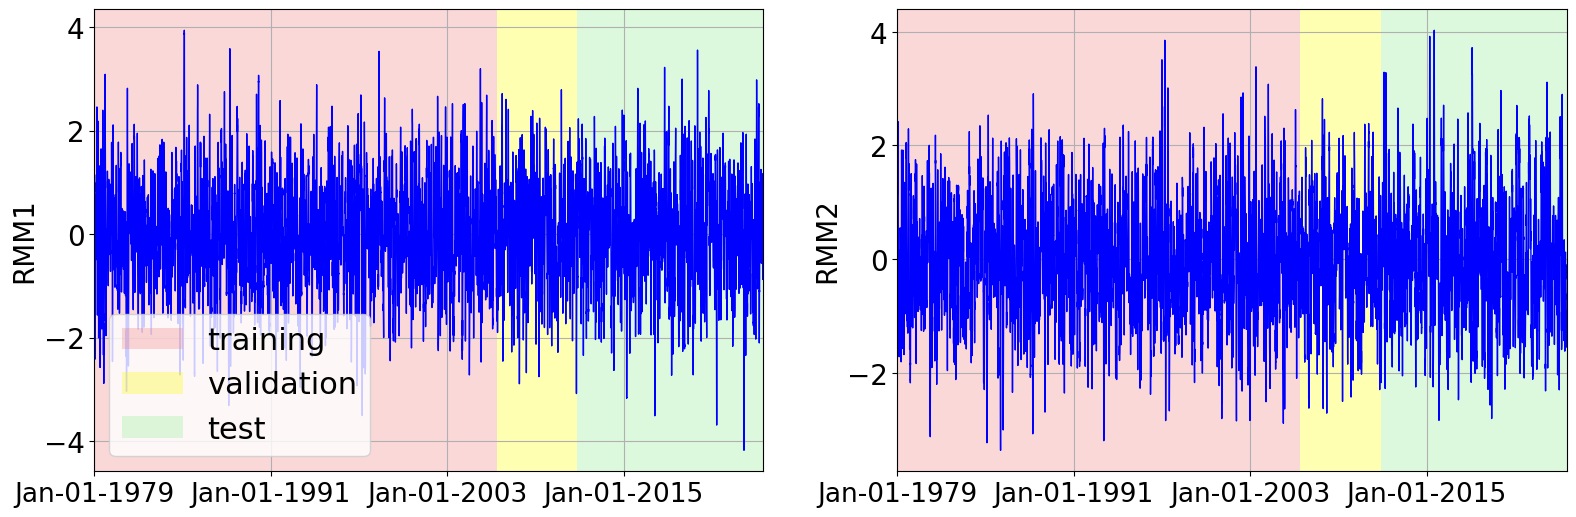

In [5]:
plt.rc('xtick', labelsize=19)  # fontsize of the tick labels
plt.rc('ytick', labelsize=20)  # fontsize of the tick labels

entire_years = entire_npzfile['year'].astype('int')
entire_months = entire_npzfile['month'].astype('int')
entire_days = entire_npzfile['day'].astype('int')
entire_df = pd.DataFrame({'year': entire_years,
                'month': entire_months,
                'day': entire_days})
entire_df_dates = pd.to_datetime(entire_df[["year", "month", "day"]], format="%Y-%m-%d")
entire_dates = pd.date_range(entire_df_dates[0], periods=len(npzfile['year']), freq='1D')

n = 10000
v = 2000
m = 5000

fig, axs = plt.subplots(1, 2, figsize=(9.5*2,6))
for k,rmm in enumerate(['RMM1','RMM2']):
    axs[k].plot(entire_dates, entire_npzfile[rmm], color='blue', linewidth=1)
    axs[k].axvspan(entire_dates[0], entire_dates[n], facecolor='lightcoral', alpha=0.3, label='training')
    axs[k].axvspan(entire_dates[n], entire_dates[n+v], facecolor='yellow', alpha=0.3, label='validation')
    axs[k].axvspan(entire_dates[n+v], entire_dates[-1], facecolor='lightgreen', alpha=0.3, label='test')


    axs[k].xaxis.set_major_locator(mdates.YearLocator(base=1))
    axs[k].margins(x=0) # so that the axis starts at the minimum date
    axs[k].set_xticks(axs[k].get_xticks()[::12]) # only show one every 10 years
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=365))
    axs[k].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d-%Y'))
    axs[k].set_ylabel(rmm, fontsize=20)
    axs[k].grid()

    axs[0].legend(fontsize=22)

plt.show()

# Forecast

## Entire

### GP model

test ids of GP model and selected S2S data are Equal! Continue...


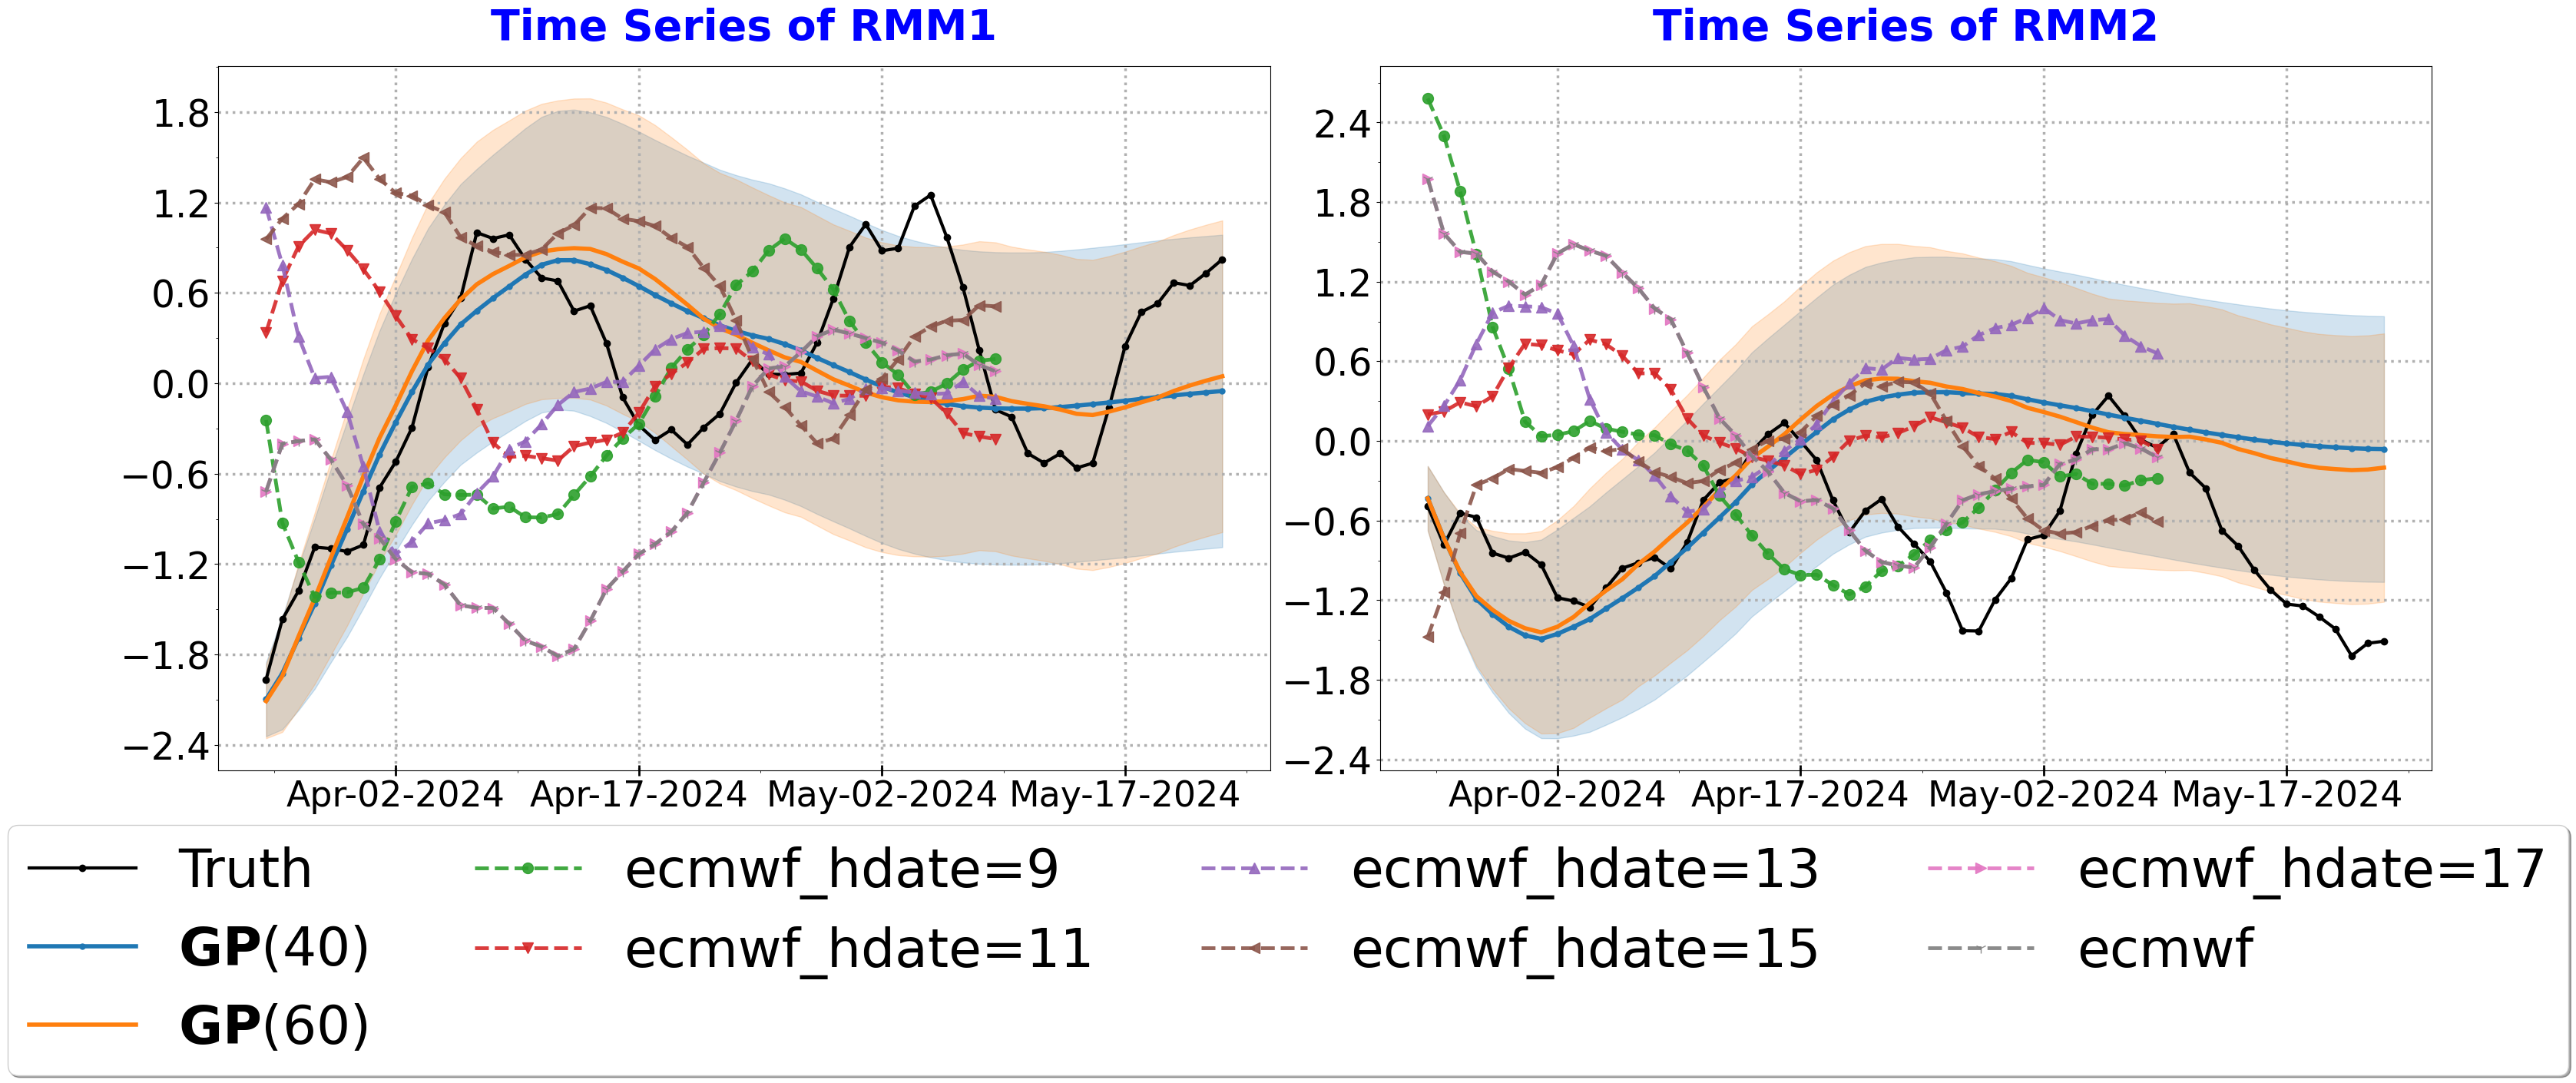

test ids of GP model and selected S2S data are Equal! Continue...


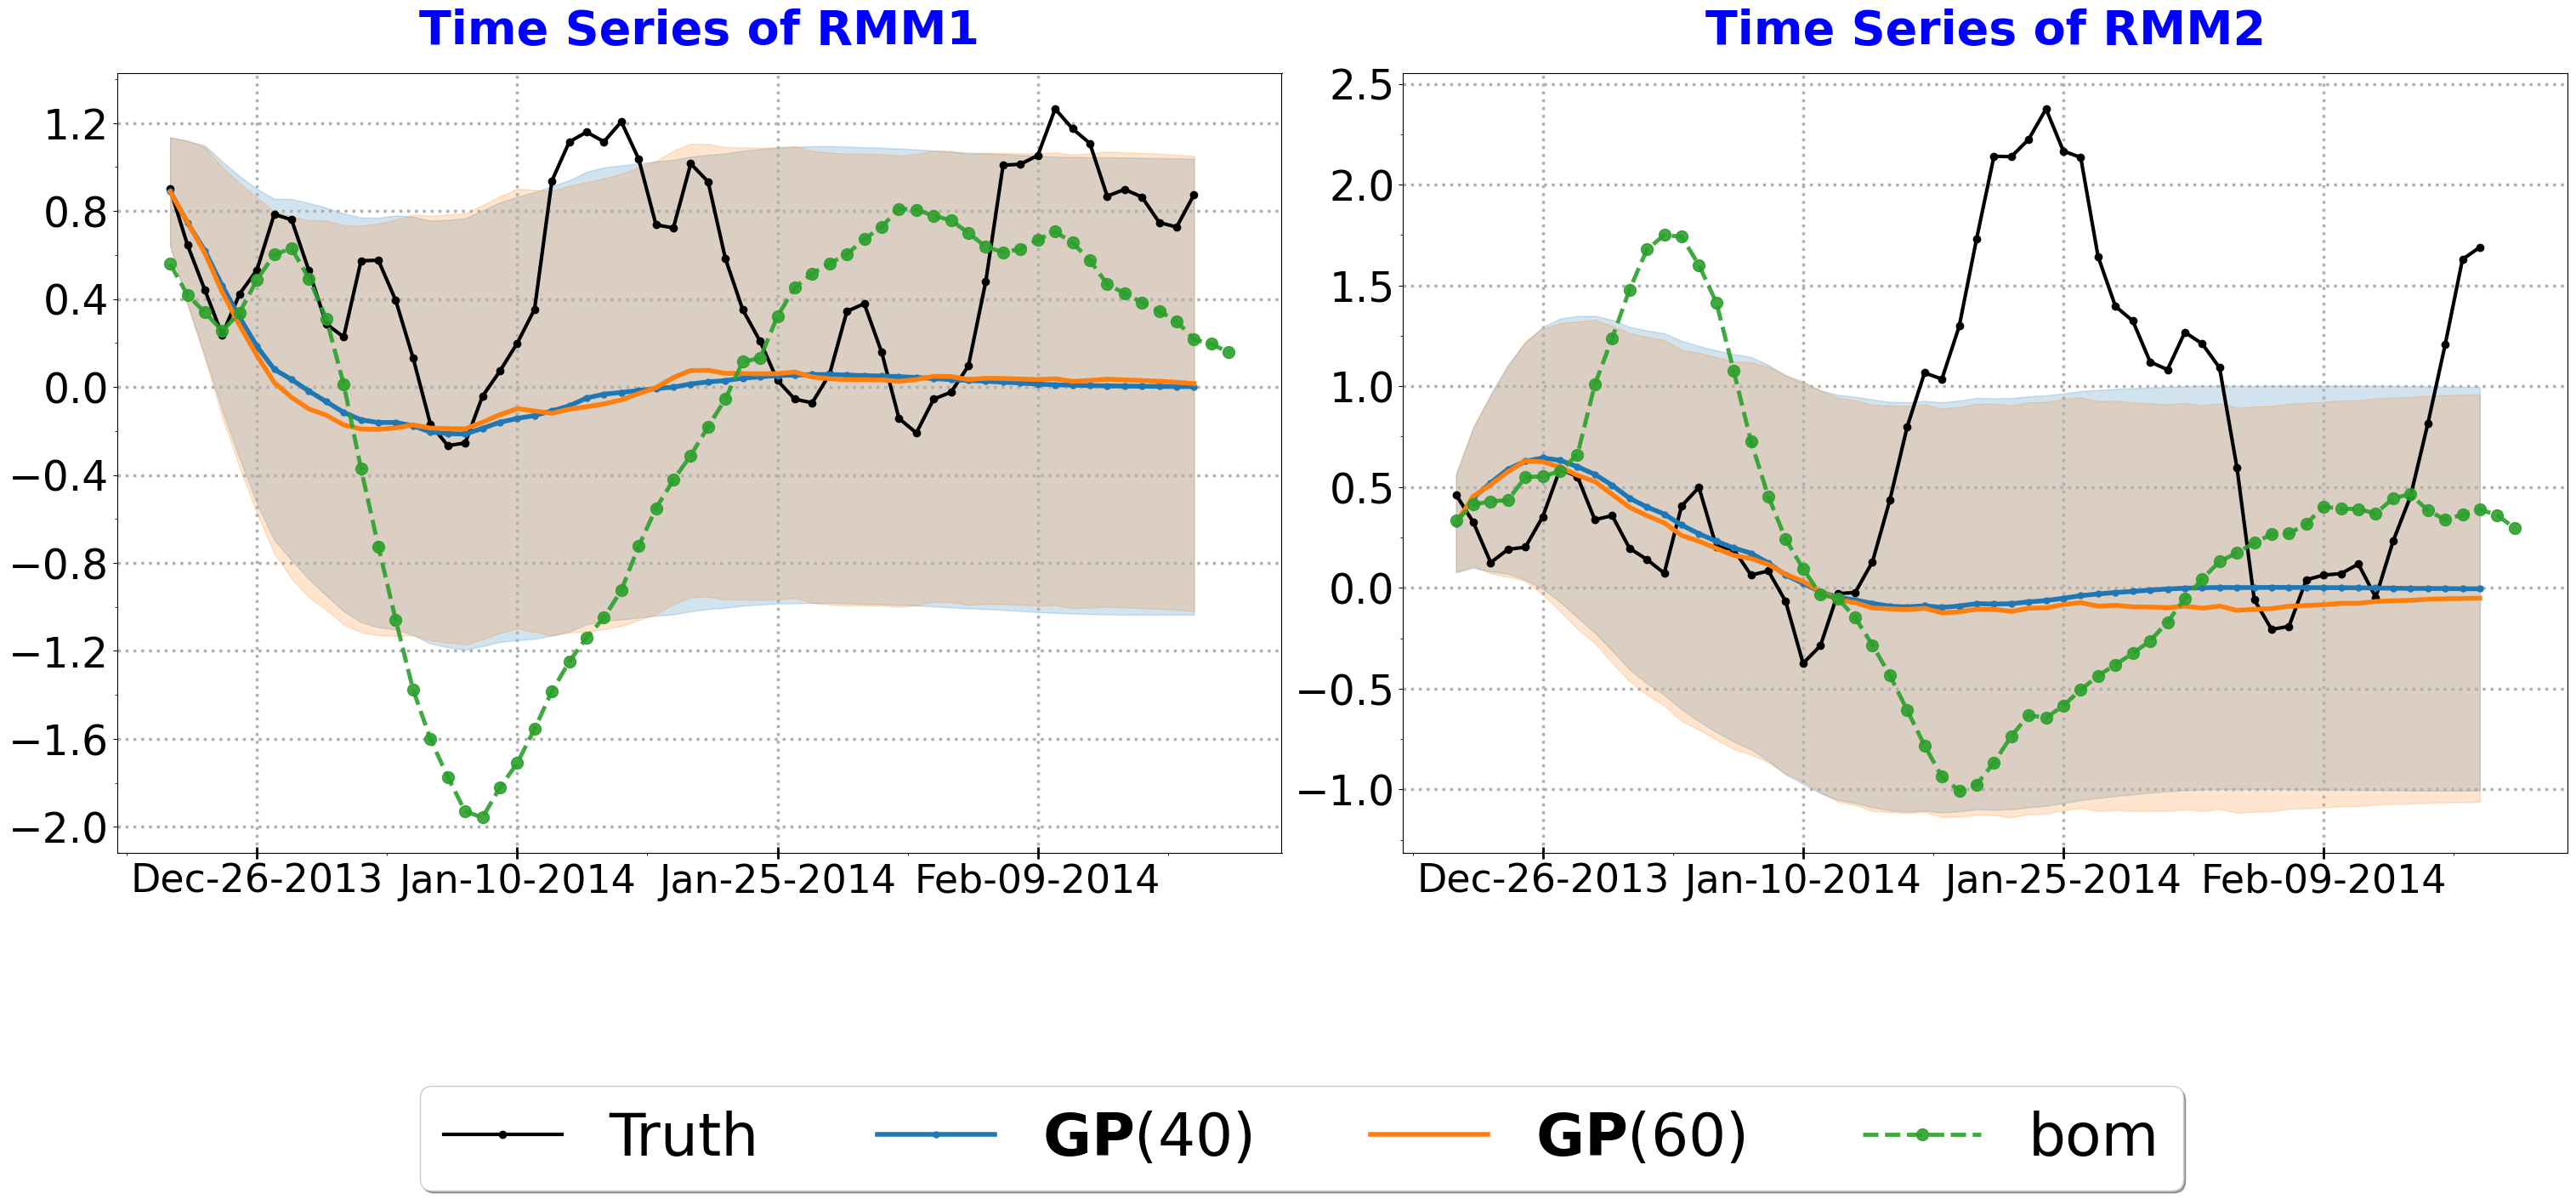

test ids of GP model and selected S2S data are Equal! Continue...


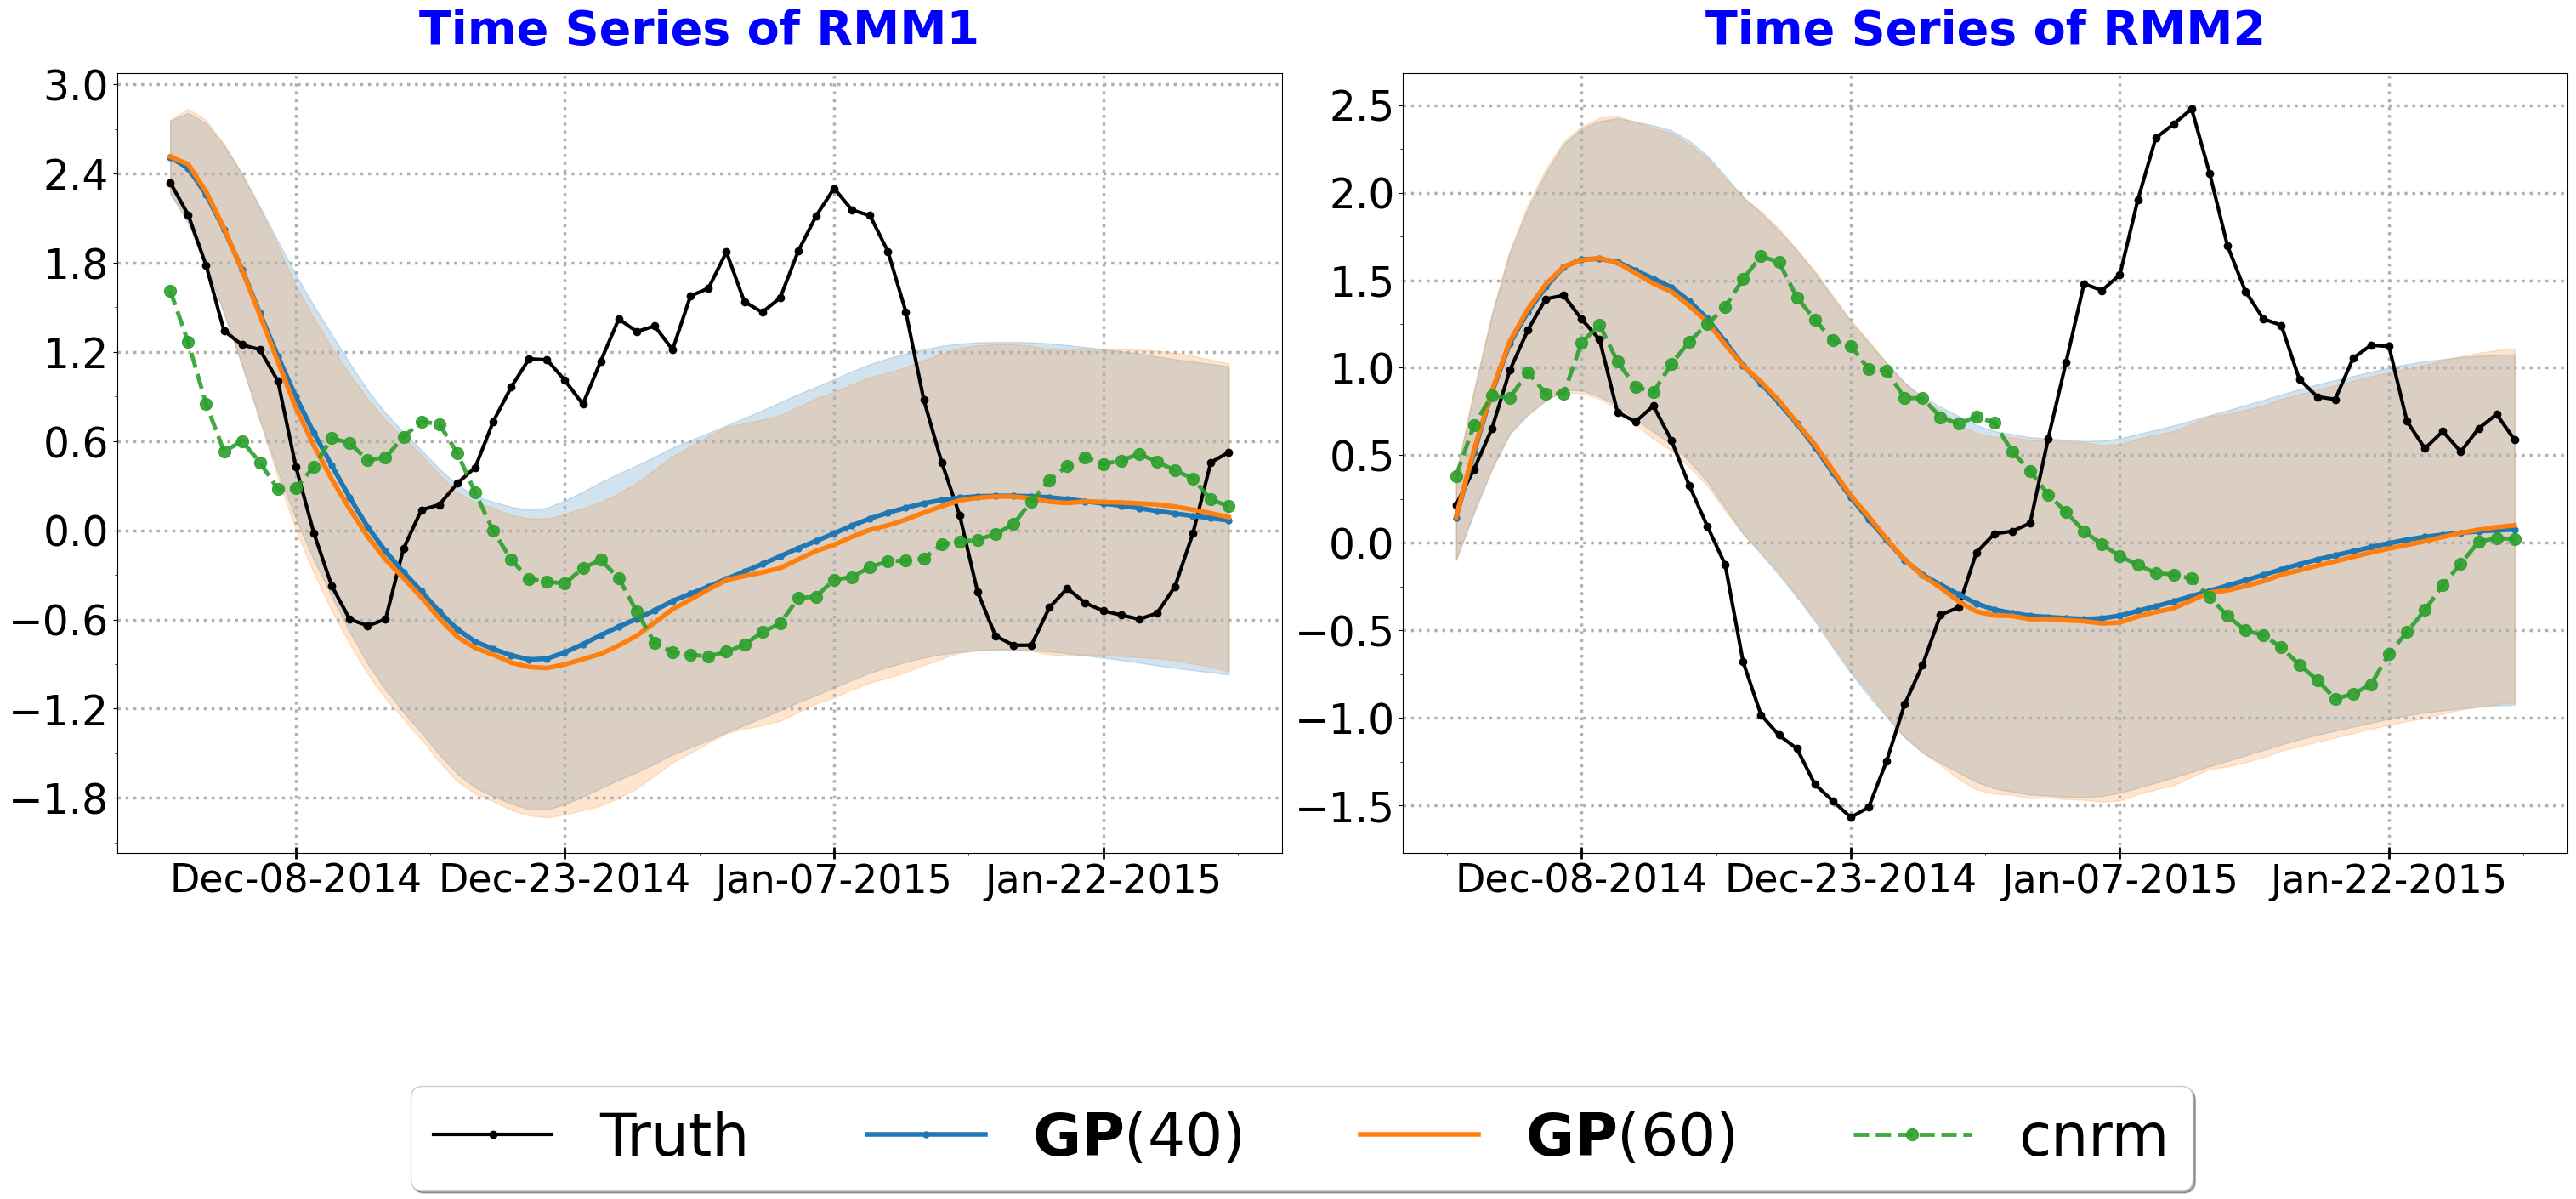

test ids of GP model and selected S2S data are Equal! Continue...


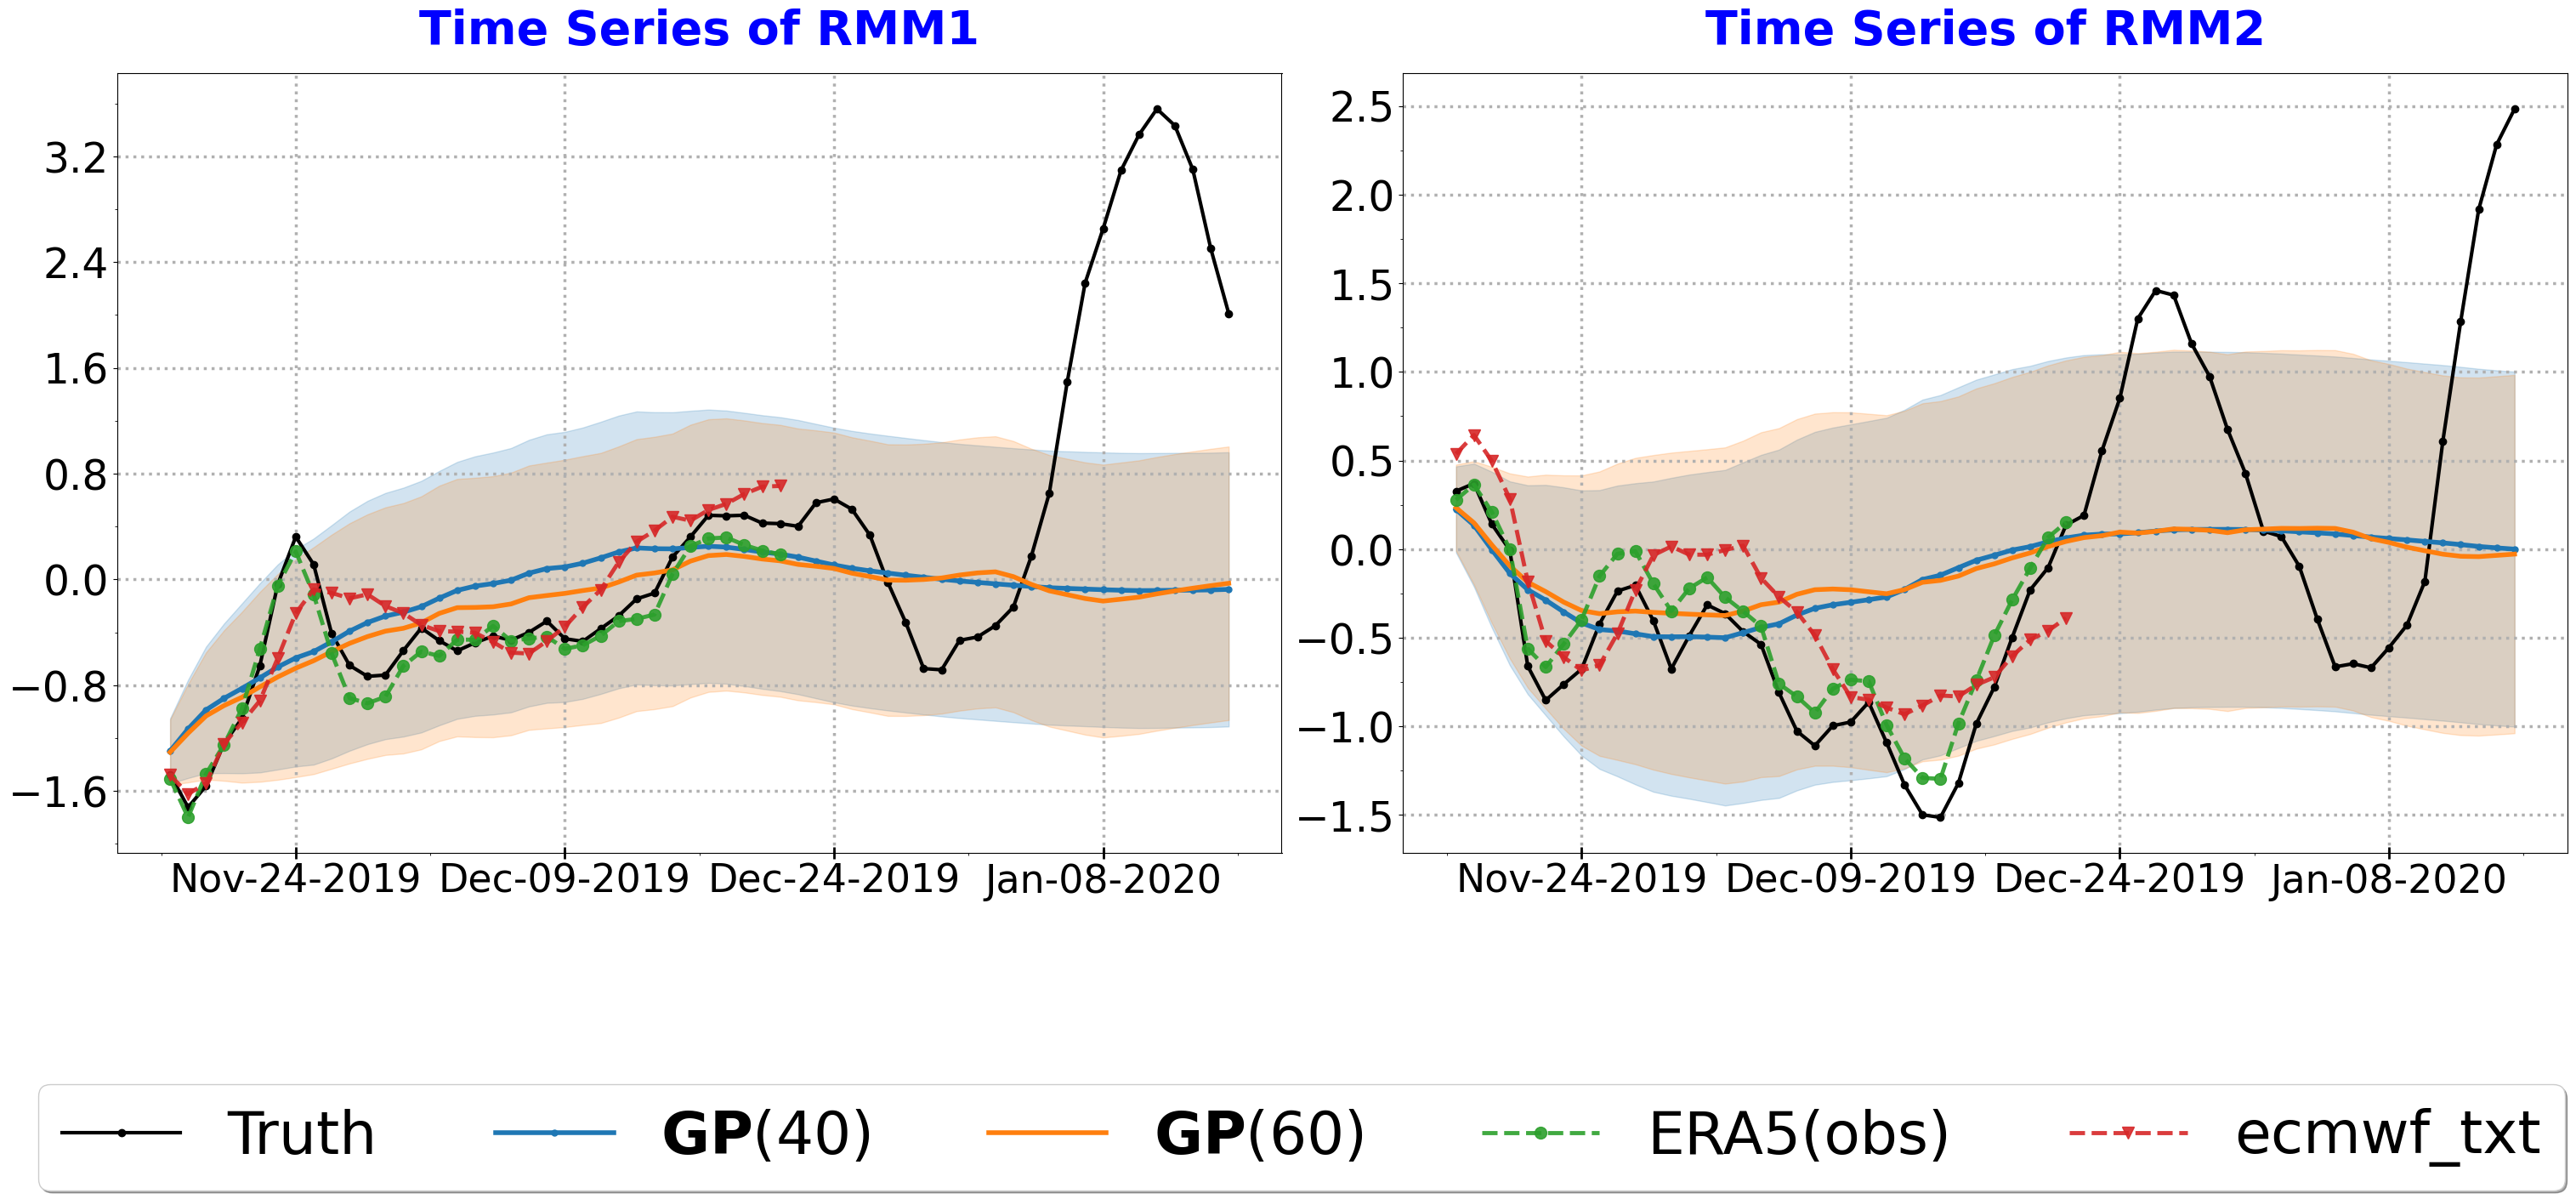

In [6]:
dir_names = ['ecmwf', 'bom', 'cnrm', 'ecmwf_txt']

dir_lens = [0]* len(dir_names)
for i, dir_name in enumerate(dir_names):
    if dir_name == 'ecmwf_txt':
        dir_lens[i] = len(s2s_data[dir_name]['ensemble_mean']['S'])
    else:
        dir_lens[i] = len(s2s_data[dir_name]['ensemble_mean_rmm1.nc']['S'])

min_dir_len = min(dir_lens) # 528
min_dir_name = dir_names[dir_lens.index(min_dir_len)] # 'cnrm'


widths = [40,60]
n = 10000
v = 2000
m = 5000
lead_time = 60
start_train = 0
n_offset = 0


# choose_dir_name = 'ecmwf'
for choose_dir_name in dir_names:
    emp_pred_model = EmpGPMJOPred(npzfile=entire_npzfile, s2s_data=s2s_data, 
                    choose_dir_name=choose_dir_name, widths=widths,
                    n=n, v=v, m=m, lead_time=lead_time, n_pred=None,
                    start_train=start_train, n_offset=n_offset, min_dir_len=min_dir_len)
    emp_pred_model.pred(test_on_choose_dir=True, test_ids=None)
    emp_pred_model.add_s2s(dir_names=dir_names, hdate_id=19)
    emp_pred_model.plot_ts(nrows=1, ncols=2, hdate_ids=[9, 11, 13, 15, 17], pred_id=-2)

In [7]:
obs_ids = (emp_pred_model.emp_model.test_ids+60).astype(int)
print(obs_ids.shape)
print(obs_ids[:10])
print(npzfile['year'][obs_ids[0]:obs_ids[0]+10])
print(npzfile['month'][obs_ids[0]:obs_ids[0]+10])
print(npzfile['day'][obs_ids[0]:obs_ids[0]+10])

print( npzfile['RMM1'][obs_ids[0]:obs_ids[0]+10] ) # observations

(528,)
[13100 13104 13107 13111 13114 13118 13121 13125 13128 13132]
[2014 2014 2014 2014 2014 2014 2014 2014 2014 2014]
[11 11 11 11 11 11 11 11 11 11]
[13 14 15 16 17 18 19 20 21 22]
[-1.7020535  -1.4193711  -1.1050652  -0.93892431 -0.85940009 -0.71344393
 -0.42405078 -0.07425113  0.22950239  0.41040945]


In [8]:
print( s2s_data['ecmwf_txt']['ensemble_mean']['RMM1(forecast)'][-1,:9] ) 
print( s2s_data['ecmwf_txt']['ensemble_mean']['RMM1(obs)'][-1,:9] )

[-1.334 -1.156 -0.955 -0.583 -0.31  -0.249 -0.423 -0.512 -0.528]
[-1.24929821 -0.97733957 -0.52537817 -0.04557023  0.21201965 -0.11399876
 -0.55838168 -0.8970589  -0.93622923]


### S2S models

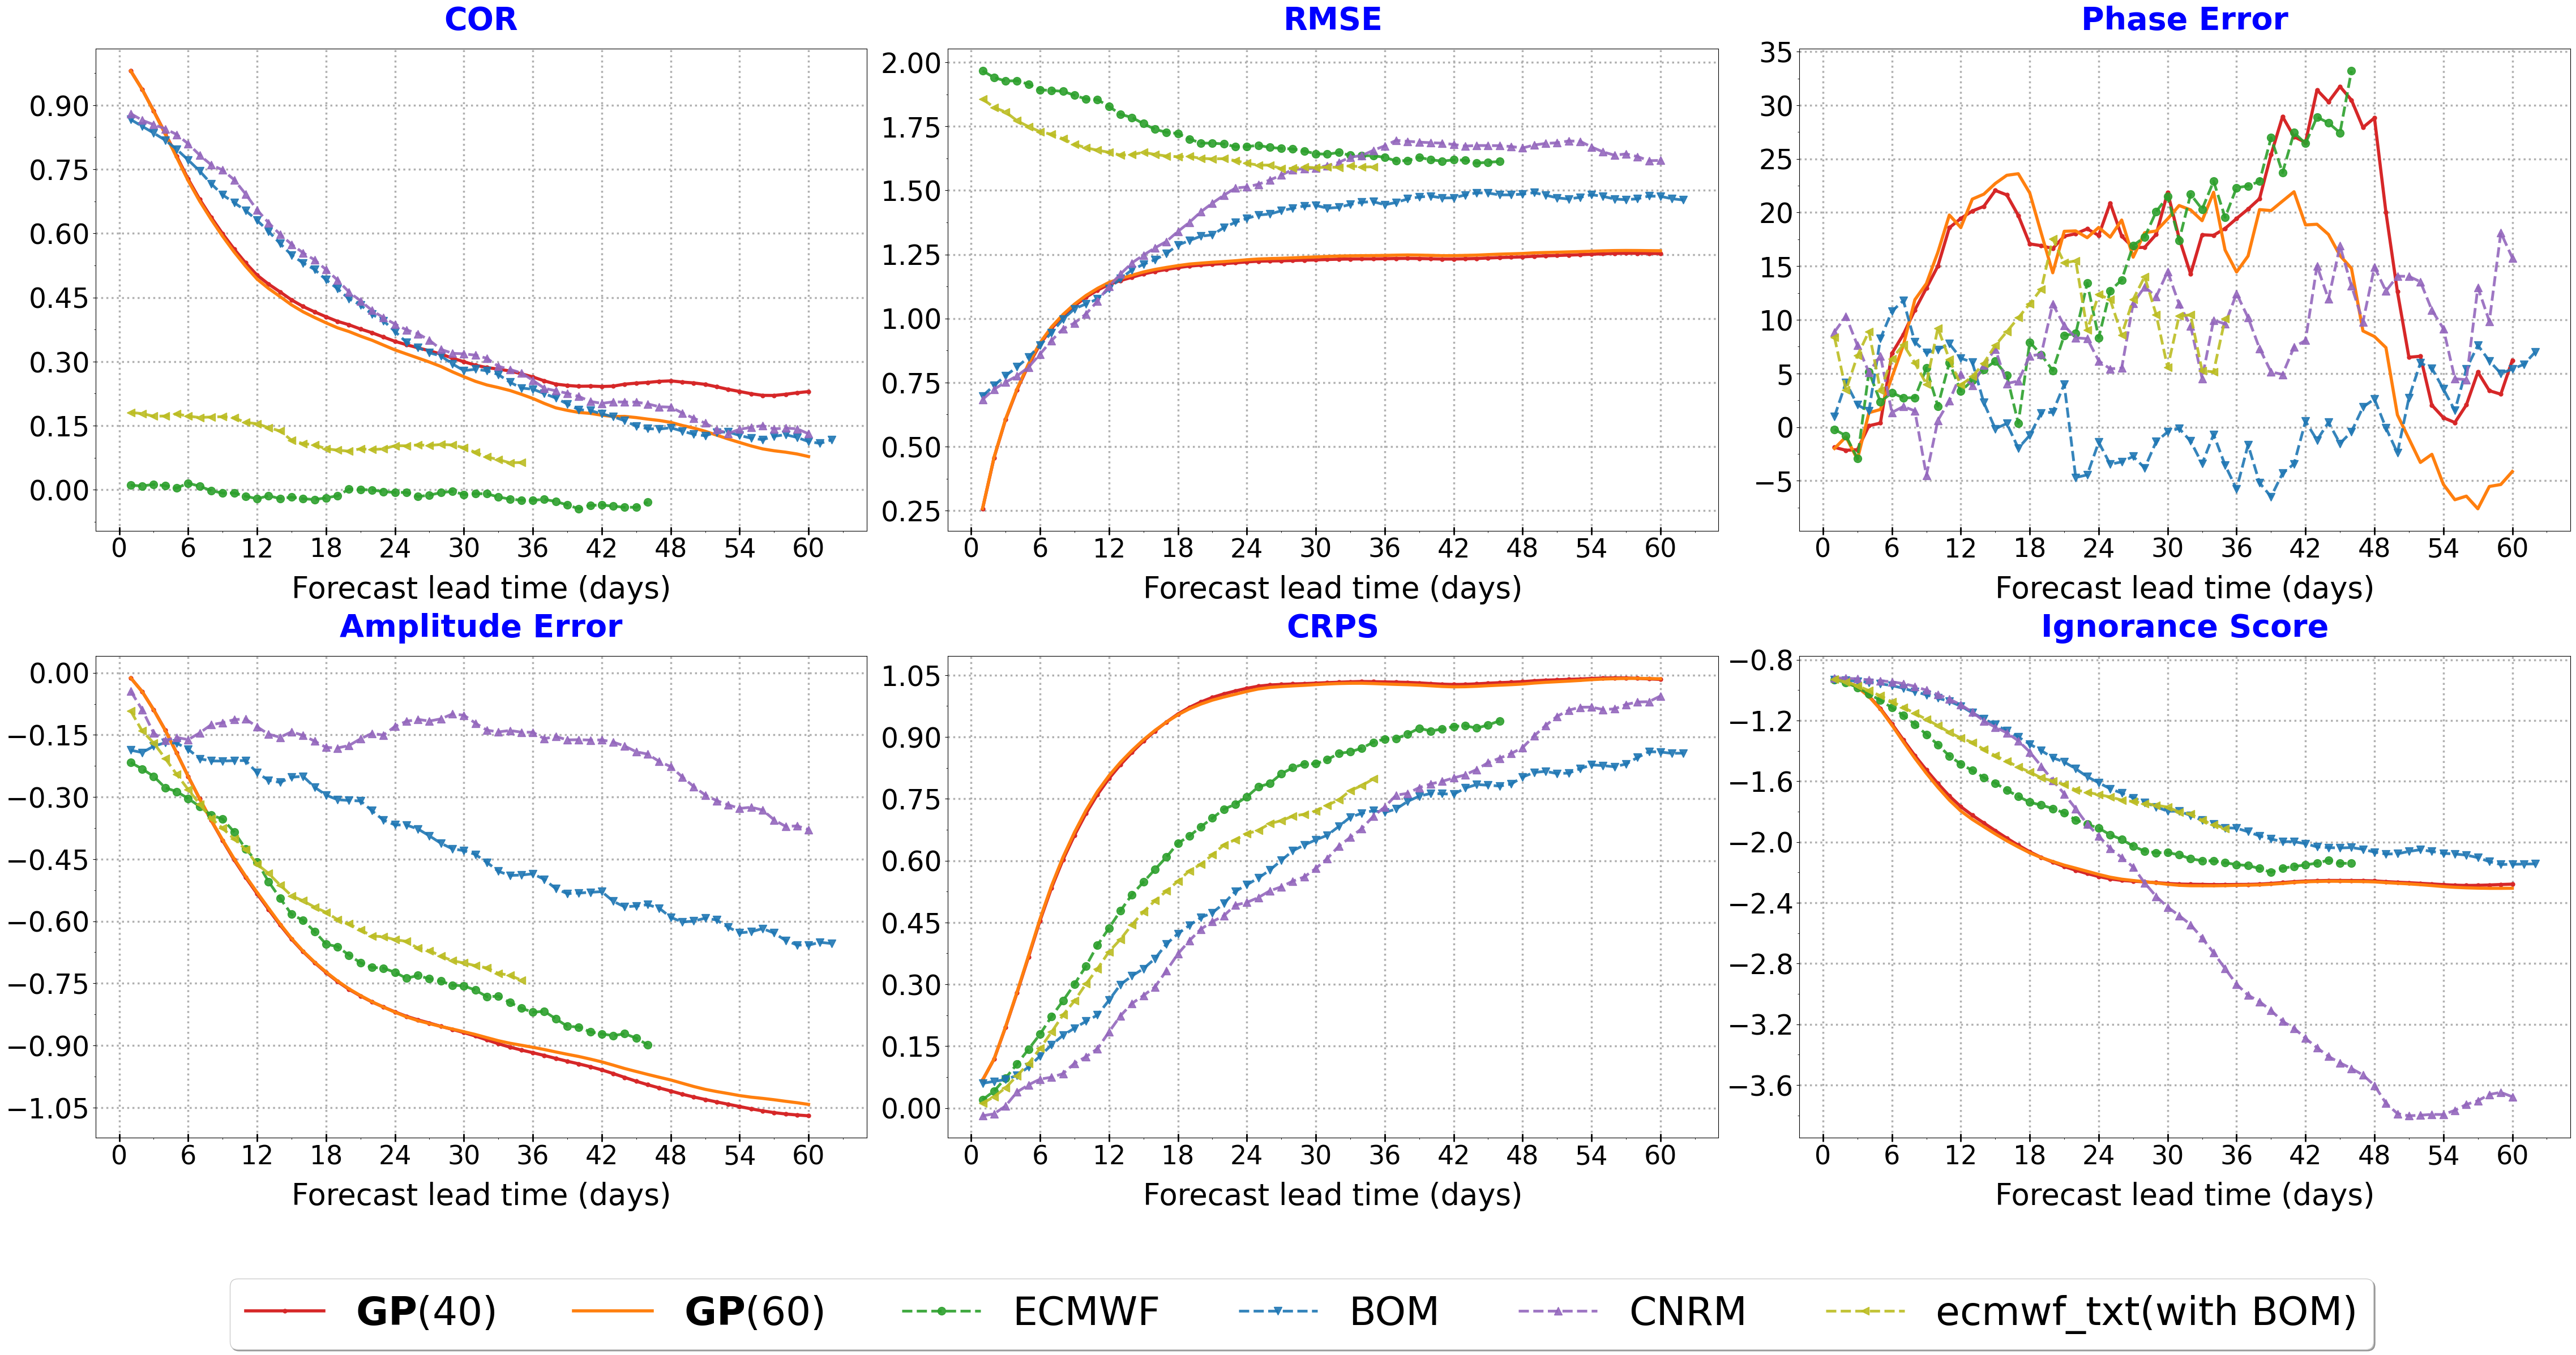

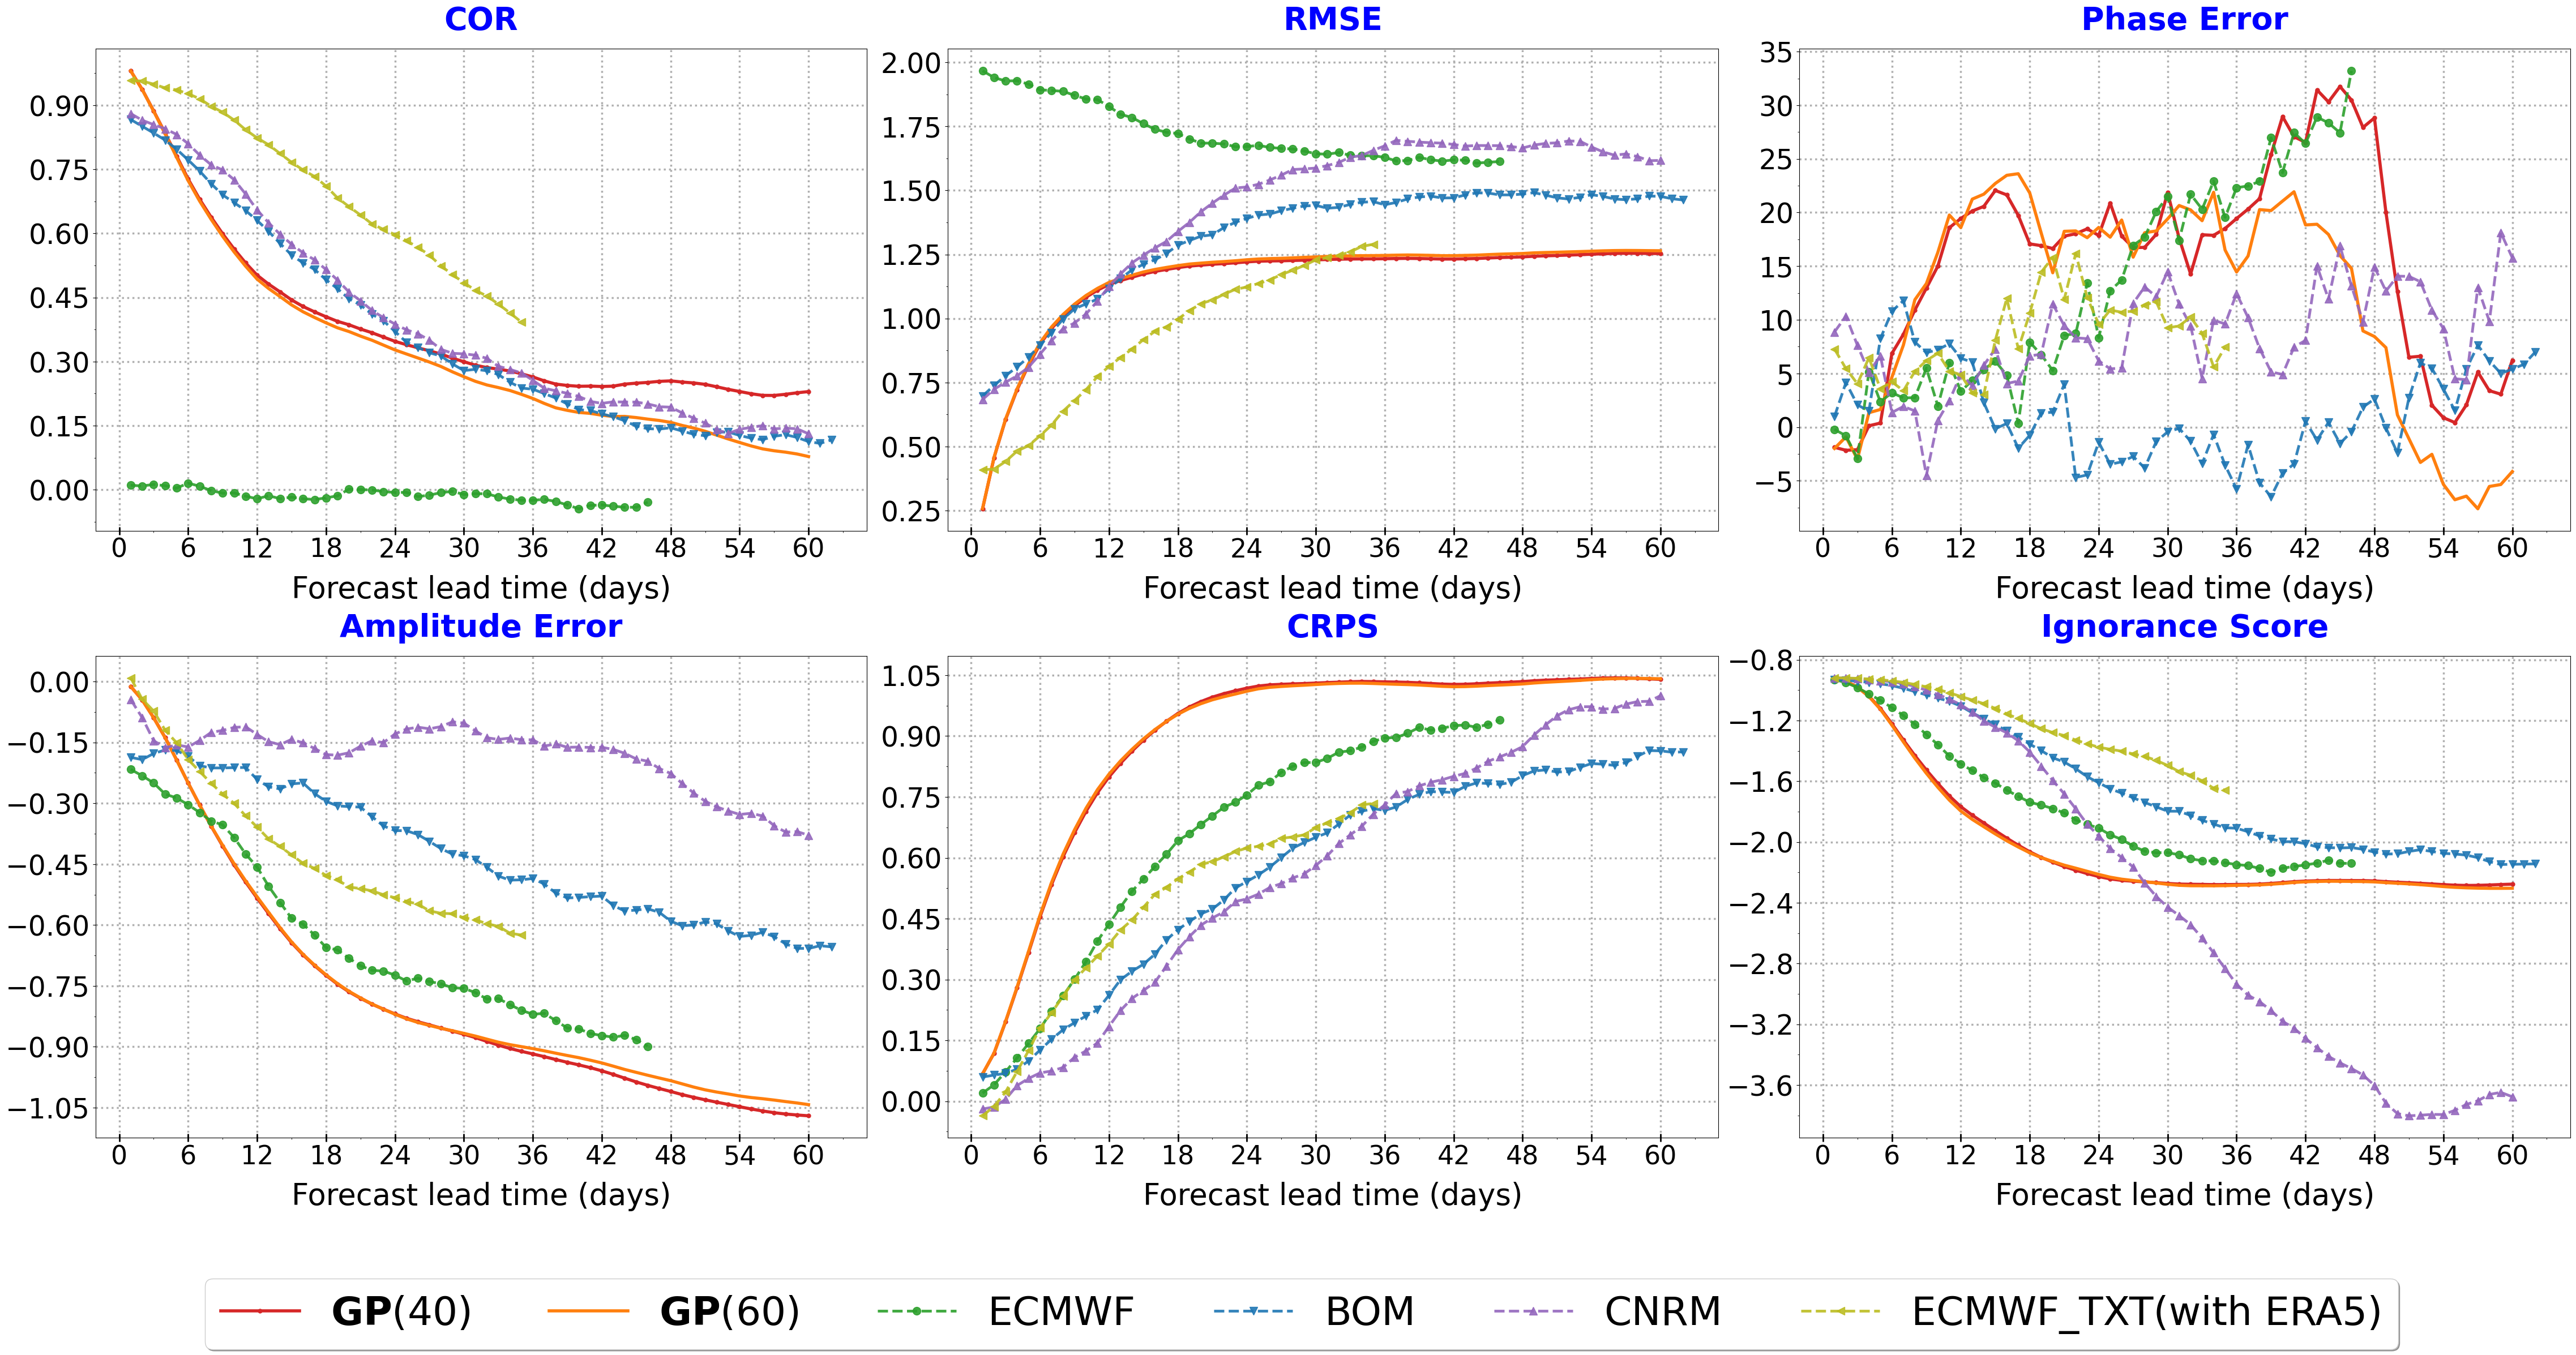

In [9]:
# np.argwhere( np.isnan( s2s_data[dir_name]['ensemble_mean_rmm1.nc']['RMM1'][9][:, 0] ) ) #'hdate' = 9, 10,...,19, set lead_time=0
# only [[ 83], [888], [889], [890], [891],[892], [918]])-th pred is NaN when hdate = 9,10,...,19

dir_names = ['ecmwf', 'bom', 'cnrm', 'ecmwf_txt']

dir_lens = [0]* len(dir_names)
for i, dir_name in enumerate(dir_names):
    if dir_name == 'ecmwf_txt':
        dir_lens[i] = len(s2s_data[dir_name]['ensemble_mean']['S'])
    else:
        dir_lens[i] = len(s2s_data[dir_name]['ensemble_mean_rmm1.nc']['S'])

min_dir_len = min(dir_lens) # 528
min_dir_name = dir_names[dir_lens.index(min_dir_len)] # 'cnrm'

choose_dir_name = 'bom'
widths = [40,60]
n = 10000
v = 2000
m = 5000
lead_time = 60
start_train = 0
n_offset = 0

model_clses=[FFNNModel]
nn_width = 60
hidden_dim = 64
num_epochs = 10
lr = 0.01
seed = 0

emp_pred_model = EmpGPMJOPred(npzfile=entire_npzfile, s2s_data=s2s_data, 
                choose_dir_name=choose_dir_name, widths=widths,
                n=n, v=v, m=m, lead_time=lead_time, n_pred=None,
                start_train=start_train, n_offset=n_offset, min_dir_len=min_dir_len)
emp_pred_model.pred(test_on_choose_dir=False, test_ids=None)
for era5_obs in [False, True]:
    emp_pred_model.add_s2s(dir_names=dir_names, hdate_id=19, era5_obs=era5_obs)
    # emp_pred_model.add_nn(model_clses=[FFNNModel], width=nn_width, lead_time=lead_time, 
    #             hidden_dim=hidden_dim, num_epochs=num_epochs, lr=lr, seed=seed, verbose=False)
    emp_pred_model.plot_metrics(nrows=2, ncols=3)

In [ ]:
print(emp_pred_model.rmse_entire[40][:10])
print(emp_pred_model.rmse_entire['ecmwf'][:10])
print(emp_pred_model.rmse_entire['bom'][:10])
print(emp_pred_model.rmse_entire['cnrm'][:10])

### Auto-corr and Cross-corr

In [ ]:
palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
colors = palette_colors[0:len(widths)]
rmms = ['RMM1','RMM2']

plt.rc('xtick', labelsize=25)  # fontsize of the tick labels
plt.rc('ytick', labelsize=25)  # fontsize of the tick labels

# Plot auto-correlation and cross-correlation
maxlags = 60
n_trains = emp_pred_model.n_trains
fig, axs = plt.subplots(1, 3, figsize=(10*3, 6))
axs[0].xcorr(entire_npzfile['RMM1'][start_train: start_train+n_trains[widths[0]]], entire_npzfile['RMM2'][start_train: start_train+n_trains[widths[0]]], usevlines=True, normed=True, maxlags=maxlags, lw=2)
axs[0].set_xlabel('Lags', fontsize=26) #, fontweight='bold'
axs[0].set_title(f'Cross-correlation for RMMs', fontsize=28) # with maxlags = {maxlags}
axs[0].grid(True)
for k, rmm in enumerate(['RMM1','RMM2']):
    axs[k+1].acorr(entire_npzfile[rmm][start_train: start_train+n_trains[widths[0]]], usevlines=True, maxlags=maxlags, normed=True, lw=2)
    axs[k+1].set_xlabel('Lags', fontsize=26)
    axs[k+1].set_title(f'Auto-correlation for {rmm}', fontsize=28)
    #axs[k+1].set_title(f'Auto-correlation for {rmm} with maxlags = {maxlags}', fontsize=20)
    axs[k+1].grid(True)
fig.savefig("../figs/emp_entire_corrs.png")

### Metrics

#### COR, RMSE, Phase error, Amplitude error

In [ ]:
plt.rc('xtick', labelsize=25)  # fontsize of the tick labels
plt.rc('ytick', labelsize=25)  # fontsize of the tick labels

cor_entire = emp_pred_model.cor_entire
rmse_entire = emp_pred_model.rmse_entire
phase_err_entire = emp_pred_model.phase_err_entire
amplitude_err_entire = emp_pred_model.amplitude_err_entire

# Plot errors
fig, axs = plt.subplots(1, 2, figsize=(18.5*2, 11.5))

# cor & rmse
cor_colors = ['red','sandybrown']
rmse_colors = ['blue','violet']
ax0 = axs[0].twinx()
for width_id, width in enumerate(widths):

    axs[0].plot(np.arange(1,lead_time+1), cor_entire[width], color=cor_colors[width_id], linewidth=2.5, marker='+', label=f'cor ({width})')
    ax0.plot(np.arange(1,lead_time+1), rmse_entire[width], color=rmse_colors[width_id], linewidth=2.5, marker='D', label=f'rmse ({width})')
    
axs[0].axhline(y = 0.5, color = 'r', linestyle = '--')
ax0.axhline(y = 1.4, color = 'dodgerblue', linestyle = '--')
axs[0].set_xlabel('Forecast lead time (days)', fontsize=35, fontweight="bold")
axs[0].set_ylabel('COR', color= 'red', fontsize=35)
#axs[0].set_title(f'COR & RMSE for Empirical GP Inference with \n training size = {n}, No. of predictions = {n_pred}', fontsize=20, fontweight="bold")
ax0.set_ylabel('RMSE', color = 'blue', fontsize=35)
axs[0].legend(fontsize=38, loc='lower left')
ax0.legend(fontsize=38, loc='center right')

major_ticks = np.linspace(0, lead_time, 16)
minor_ticks = np.linspace(0.0, 1.0, 11)
axs[0].set_xticks(major_ticks)
axs[0].set_yticks(minor_ticks)
axs[0].grid(which="major",alpha=0.6)

# phase err & amplitude err
phase_err_colors = ['orange','gold']
amplitude_err_colors = ['green','cyan']
ax1 = axs[1].twinx()
for width_id, width in enumerate(widths):
    axs[1].plot(np.arange(1,lead_time+1), phase_err_entire[width], color=phase_err_colors[width_id], linewidth=2.5, marker='+', label=f'phase error ({width})')
    ax1.plot(np.arange(1,lead_time+1), amplitude_err_entire[width], color=amplitude_err_colors[width_id], linewidth=2.5, marker='D', label=f'amplitude error ({width})')

axs[1].axhline(y = 0.0, color = 'r', linestyle = '--')
axs[1].set_xlabel('Forecast lead time (days)', fontsize=35, fontweight="bold")
axs[1].set_ylabel('Phase errors', color='orange', fontsize=35)
#axs[1].set_title(f'Phase & Ampltidue errors for Empirical GP Inference with \n training size = {n}, No. of predictions = {n_pred}', fontsize=20, fontweight="bold")
ax1.set_ylabel('Amplitude errors', color='green', fontsize=35)
axs[1].legend(fontsize=38, loc='lower left')
ax1.legend(fontsize=38, loc='upper right')

major_ticks = np.linspace(0, lead_time, 16)#31
minor_ticks = np.linspace(-20, 20, 9)
axs[1].set_xticks(major_ticks)
axs[1].set_yticks(minor_ticks)
axs[1].grid(which="major",alpha=0.6)

fig.savefig("../figs/emp_entire_errs.png")
plt.show()

#### HSS

In [ ]:
# Plot hss heatmap
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
lead_time_select = 40

hss_entire = emp_pred_model.hss_entire
hss_signif_entire = emp_pred_model.hss_signif_entire

for width_id, width in enumerate(widths):
    fig, ax = plt.subplots(1, 1, figsize = (18, 12))

    heatmap_data = hss_entire[width][:,:lead_time_select]
    bounds = np.linspace(-1, 1, 21)
    norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
    pcm = ax.pcolor(np.flip(heatmap_data, axis=0), norm=norm, cmap='RdBu_r', edgecolors='k', linewidths=2)

    # Set ticks in center of cells
    ax.set_xticks(np.arange(0,heatmap_data.shape[1],2) + 0.5, minor=False)
    ax.set_yticks(np.arange(0,heatmap_data.shape[0]) + 0.5, minor=False)

    # Rotate the xlabels. Set both x and y labels to headers[1:]
    xticklabels = np.arange(1, lead_time_select+1, 2)
    yticklabels = [i for i in np.flip(np.arange(1,9))] + ['inactive']
    ax.set_xticklabels(xticklabels, fontsize=25)
    ax.set_yticklabels(yticklabels, fontsize=25)

    # The colorbar inherits the "extend" argument from BoundaryNorm
    cbar = fig.colorbar(pcm, ax=ax, orientation='horizontal')
    #cbar.ax.set_xticklabels( np.linspace(start=-1, stop=1, num=21, endpoint=True))
    cbar.set_label('HSS', size=25)
    ax.set_xlabel('Forcast lead time (days)', fontsize=25)
    ax.set_ylabel('MJO Phase', fontsize=21)
    ax.set_title(f'HSS heatmap with lag = {width}', fontsize=25, fontweight="bold")

    xpos_signif = np.argwhere(np.flip(hss_signif_entire[width][:,:lead_time_select],axis=0) == 'X')[:,1] + 0.5
    ypos_signif = np.argwhere(np.flip(hss_signif_entire[width][:,:lead_time_select],axis=0) == 'X')[:,0] + 0.5
    ax.scatter(xpos_signif, ypos_signif, marker="x", color="black", s=256, linewidths=2)

    plt.show()

### Time Series

In [ ]:
palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors
colors = palette_colors[0:len(widths)]

plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
alpha = 0.25
linewidth = 3.5

# Plot predictions with observations
Ns = 1000
pred_id = 90 # 90, 172, 243, 302, 363, 394
lead_time = 60

#for i in range(pred_id,pred_id+1):#range(n_pred):
#start_ids = np.arange(i + start_test + 1, i + start_test + width + 1)
pred_ids = np.arange(pred_id + start_tests[widths[0]] + widths[0], pred_id + start_tests[widths[0]] + widths[0] + lead_time)

years = obs[widths[0]]['year'][pred_id, :].astype('int')
months = obs[widths[0]]['month'][pred_id, :].astype('int')
days = obs[widths[0]]['day'][pred_id, :].astype('int')
df = pd.DataFrame({'year': years,
                'month': months,
                'day': days})
df_dates = pd.to_datetime(df[["year", "month", "day"]], format="%Y-%m-%d")
dates = pd.date_range(df_dates[0], periods=lead_time, freq='1D')

start_date = dates[0].strftime('%b') + '-' + dates[0].strftime('%d') + '-' + dates[0].strftime('%Y')
end_date = dates[-1].strftime('%b') + '-' + dates[-1].strftime('%d') + '-' + dates[-1].strftime('%Y')


fig, axs = plt.subplots(2, 2, figsize=(14*2, 10*2))
for k, rmm in enumerate(rmms):
    #axs[k].plot(start_ids, npzfile[rmm][start_ids], color='black', marker='^', label='start interval')
    axs[0,k].plot(dates, obs[widths[0]][rmm][pred_id,:], color='black', marker='o', label='truth') # pred_ids...
    for width, color in zip(widths,colors):    
        # Plot predictive means as blue line
        axs[0,k].plot(dates, observed_preds[width][rmm][pred_id,:], color, linewidth=linewidth, marker='x',label=f'predict ({width})')
        # shade between the lower and upper confidence bounds
        axs[0,k].fill_between(dates, lower_confs[width][rmm][pred_id,:], upper_confs[width][rmm][pred_id,:], alpha=alpha, color=color, label=f'CI ({width})')
    axs[0,0].legend(fontsize=25)
    #axs[k].legend(['truth', f'predict ({widths[0]})',f'CI ({widths[0]})', f'predict ({widths[1]})',f'CI ({widths[1]})'],fontsize=25)
    axs[0,k].xaxis.set_major_locator(mdates.DayLocator(interval=15))
    axs[0,k].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d-%Y'))
    axs[0,k].grid()
    axs[0,k].set_title(f'{lead_time}--Days Time Series of {rmm}',fontsize=20, fontweight="bold")
    #axs[k].set_title(f'{lead_time}--Days Time Series of MJO {rmm} with training size = {n} \n for {start_date} to {end_date}',fontsize=20, fontweight="bold")
#fig.savefig("../figs/emp_entire_ts_rmms.png")





# calc phase & amplitude of samples
rmm_angle_mean = {}
rmm_angle_std = {}
amplitude_mean = {}
amplitude_std = {}
for width in widths:
    rmm_angle_mean_width = np.zeros(lead_time)
    rmm_angle_std_width = np.zeros(lead_time)
    amplitude_mean_width = np.zeros(lead_time)
    amplitude_std_width = np.zeros(lead_time)
    for j in range(lead_time):
        pred_mean = np.array( [ observed_preds[width]['RMM1'][pred_id, j] , observed_preds[width]['RMM2'][pred_id, j] ] ) # (2, ) array
        true_mean = np.array( [ obs[width]['RMM1'][pred_id, j] , obs[width]['RMM2'][pred_id, j] ] ) # (2, ) array
        pred_cov = emp_model.Kcond_correct[j] # (2, 2) array
        rmms_sample = np.random.multivariate_normal(mean=pred_mean, cov=pred_cov, size=Ns) # (Ns, 2) array

        # calc phase (arctan2)
        rmm_angle_sample = np.arctan2(rmms_sample[:,1],rmms_sample[:,0]) * 180 / np.pi + 180 # (Ns, ) array
        rmm_angle_mean_width[j] = np.mean(rmm_angle_sample, axis=0)#np.arctan2(pred_mean[1],pred_mean[0])  * 180 / np.pi + 180  # np.mean(rmm_angle_sample, axis=0)# (1, ) array 
        rmm_angle_var = ( rmm_angle_sample[None,:] - rmm_angle_mean_width[j] ) @ ( rmm_angle_sample[:,None] - rmm_angle_mean_width[j] ) / (Ns-1)
        rmm_angle_std_width[j] = np.sqrt(rmm_angle_var[0,0])

        # calc amplitude
        amplitude_sample = np.sqrt( np.square(rmms_sample[:,0]) + np.square(rmms_sample[:,1]) ) # (Ns, ) array
        amplitude_mean_width[j] = np.mean(amplitude_sample, axis=0)#np.sqrt( np.square(pred_mean[0]) + np.square(pred_mean[1]) ) # (1, ) array
        amplitude_var = ( amplitude_sample[None,:] - amplitude_mean_width[j] ) @ ( amplitude_sample[:,None] - amplitude_mean_width[j] ) / (Ns-1)
        amplitude_std_width[j] = np.sqrt(amplitude_var[0,0])
        
    rmm_angle_mean[width] = rmm_angle_mean_width
    rmm_angle_std[width] = rmm_angle_std_width
    amplitude_mean[width] = amplitude_mean_width
    amplitude_std[width] = amplitude_std_width

# phase(arctan2)
#fig, axs = plt.subplots(2, 1, figsize=(14,10*2))
obs_rmm_angle = np.arctan2( obs[widths[0]]['RMM2'][pred_id,:], obs[widths[0]]['RMM1'][pred_id,:] ) * 180 / np.pi + 180 
axs[1,0].plot(dates, obs_rmm_angle, color='black', marker='o', label='truth') # pred_ids...
for width, color in zip(widths,colors):    
    # Plot predictive means as blue line
    axs[1,0].plot(dates, rmm_angle_mean[width], color, linewidth=linewidth, marker='x',label=f'predict ({width})')
    # shade between the lower and upper confidence bounds
    axs[1,0].fill_between(dates, rmm_angle_mean[width] - 1.00 * rmm_angle_std[width], rmm_angle_mean[width] + 1.00 * rmm_angle_std[width], alpha=alpha, color=color, label=f'CI ({width})')
#axs[1,0].legend(fontsize=25)
axs[1,0].xaxis.set_major_locator(mdates.DayLocator(interval=15))
axs[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d-%Y'))
axs[1,0].grid()
axs[1,0].set_title(f'{lead_time}--Days Time Series of Phase (Angle)',fontsize=20, fontweight="bold")
#axs[0].set_title(f'{lead_time}--Days Time Series of angle of MJO RMMs with training size = {n} \n for {start_date} to {end_date}',fontsize=20, fontweight="bold")
#fig.savefig("../figs/emp_entire_ts_phase")

# amplitude
axs[1,1].plot(dates, obs[widths[0]]['amplitude'][pred_id,:], color='black', marker='o', label='truth') # pred_ids...
for width, color in zip(widths,colors):    
    # Plot predictive means as blue line
    axs[1,1].plot(dates, amplitude_mean[width], color, linewidth=linewidth, marker='x',label=f'predict ({width})')
    # shade between the lower and upper confidence bounds
    axs[1,1].fill_between(dates, amplitude_mean[width] - 1.00 * amplitude_std[width], amplitude_mean[width] + 1.00 * amplitude_std[width], alpha=alpha, color=color, label=f'CI ({width})')
#axs[1,1].legend(fontsize=25)
axs[1,1].xaxis.set_major_locator(mdates.DayLocator(interval=15))
axs[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d-%Y'))
axs[1,1].grid()
axs[1,1].set_title(f'{lead_time}--Days Time Series of Amplitude',fontsize=20, fontweight="bold")
#axs[1,1].set_title(f'{lead_time}--Days Time Series of MJO Amplitude with training size = {n} \n for {start_date} to {end_date}',fontsize=20, fontweight="bold")
#fig.savefig(f"../figs/emp_entire_ts_phase_amplitude_{dates[0].strftime('%b')}-{dates[-1].strftime('%b')}")

plt.show()

### Phase Diagram

#### Figures

In [ ]:
palette_colors = list(mcolors.TABLEAU_COLORS.keys())
month_colors = ['tab:red','tab:purple', 'tab:cyan', 'tab:orange', 'tab:green', 'tab:blue', 'gold','tab:green', 'tab:orange', 'hotpink',
    'tab:olive', 'darkblue']
labelday = 5  # label every fifth day

# plt.rc("text", usetex=True)
# plt.rc("text.latex", preamble=r"\usepackage{amsmath}")

plt.rc('xtick', labelsize=25)  # fontsize of the tick labels
plt.rc('ytick', labelsize=25)  # fontsize of the tick labels

Ns = 1000
pred_id = 172 # 90, 172, 243, 302, 363, 394
lead_time = 60

p = 2
alpha = 1-0.68
s = chi2.isf(alpha, p) # scale of the ellipse using the inverse cumulative distrubution function

for width_id, width in enumerate(widths):
    fig, axs = plt.subplots(1, 2, figsize=(10*2, 10))
    for pred_id_id, pred_id in enumerate([172, 243]):
        ax = axs[pred_id_id]

        # dates of the time period for the plot
        start_year = obs[width]['year'][pred_id, 0].astype('int')
        start_month = calendar.month_abbr[ obs[width]['month'][pred_id, 0].astype('int') ]
        start_day = obs[width]['day'][pred_id, 0].astype('int')
        start_date =  f'{start_month}-{start_day:02d}-{start_year}'

        end_year = obs[width]['year'][pred_id, lead_time-1].astype('int')
        end_month = calendar.month_abbr[ obs[width]['month'][pred_id,lead_time-1].astype('int') ]
        end_day = obs[width]['day'][pred_id, lead_time-1].astype('int')
        end_date =  f'{end_month}-{end_day:02d}-{end_year}'

        months_temp, ind = np.unique(obs[width]['month'][pred_id, :], return_index=True)
        months = months_temp[np.argsort(ind)].astype('int')

        #fig, ax = plt.subplots(1, 1, figsize=(14, 14))

        ax.plot(obs[width]['RMM1'][pred_id, :lead_time], obs[width]['RMM2'][pred_id, :lead_time], '->', color='black', linewidth=2, label="truth")
        for month_id, month in enumerate(months):
            if len(months) == 2:
                    ax.text(-0.5 + 1 * month_id, -3.1, calendar.month_abbr[month], horizontalalignment='center', verticalalignment='bottom',
                    color=month_colors[month-1], fontsize=20, fontweight="bold")
            if len(months) == 3:
                    ax.text(0.0 + 1 * (month_id-1), -3.1, calendar.month_abbr[month], horizontalalignment='center', verticalalignment='bottom',
                    color=month_colors[month-1], fontsize=20, fontweight="bold")
            
            month_ids = np.where( (obs[width]['month'][pred_id, :]).astype('int') == month )[0]
            if month_id < len(months)-1:
                    month_ids_add = np.hstack(( month_ids, month_ids[-1]+1 ))
            else:
                    month_ids_add = month_ids
            ax.plot(observed_preds[width]['RMM1'][pred_id, month_ids_add], observed_preds[width]['RMM2'][pred_id, month_ids_add], '->', color=month_colors[month-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[month]})")

        ax.scatter(observed_preds[width]['RMM1'][pred_id, 0], observed_preds[width]['RMM2'][pred_id, 0], marker='o', color=month_colors[months[0]-1], linewidths=2.5)
        ax.scatter(observed_preds[width]['RMM1'][pred_id, lead_time-1], observed_preds[width]['RMM2'][pred_id, lead_time-1], marker='o', color=month_colors[months[-1]-1], linewidths=2.5)
        if pred_id_id == 0:
                ax.text(observed_preds[width]['RMM1'][pred_id, 0]+0.05, observed_preds[width]['RMM2'][pred_id, 0]-0.2, 'start', color=month_colors[months[0]-1], fontsize = 15)
                ax.text(observed_preds[width]['RMM1'][pred_id, lead_time-1]+0.01, observed_preds[width]['RMM2'][pred_id, lead_time-1]+0.01, 'end', color=month_colors[months[-1]-1], fontsize = 15)

        if pred_id_id == 1:
                ax.text(observed_preds[width]['RMM1'][pred_id, 0]-0.01, observed_preds[width]['RMM2'][pred_id, 0]+0.1, 'start', color=month_colors[months[0]-1], fontsize = 15)
                ax.text(observed_preds[width]['RMM1'][pred_id, lead_time-1]+0.05, observed_preds[width]['RMM2'][pred_id, lead_time-1]+0.1, 'end', color=month_colors[months[-1]-1], fontsize = 15)

        for j in range(lead_time):
            pred_mean = np.array( [ observed_preds[width]['RMM1'][pred_id, j] , observed_preds[width]['RMM2'][pred_id, j] ] ) # (2, ) array
            true_mean = np.array( [ obs[width]['RMM1'][pred_id, j] , obs[width]['RMM2'][pred_id, j] ] ) # (2, ) array
            pred_cov = emp_model.Kcond_correct[j] # (2, 2) array
            rmms_sample = np.random.multivariate_normal(mean=pred_mean, cov=pred_cov, size=Ns) # (Ns, 2) array
            rows_drop = np.where(np.abs(rmms_sample) >= 4)[0]
            rmms_sample_new = np.delete(rmms_sample, rows_drop, axis=0) # (Ns - # of rows_drop, 2) array

            eig_vals, eig_vecs = np.linalg.eig(pred_cov)
            eig_id_max = np.argmax(eig_vals)
            eig_id_min = np.argmin(eig_vals)

            #ax_samples = ax.scatter(rmms_sample_new [:, 0], rmms_sample_new [:, 1], s=1, color='lightblue', label="sampled RMMs")
            
            month_j = (obs[width]['month'][pred_id, j]).astype('int')
            # ax.plot(pred_mean[0], pred_mean[1], '->', color=month_colors[month_j-1], linewidth=2, label="Predictive mean")
            # ax.plot(true_mean[0], true_mean[1], '->', color='black', linewidth=2, label="Truth")

            ell = patches.Ellipse(
            xy = (pred_mean[0], pred_mean[1]),
            width = 2 * np.sqrt(s * eig_vals[eig_id_max]),
            height = 2 * np.sqrt(s * eig_vals[eig_id_min]),
            angle = np.arctan2(eig_vecs[eig_id_max, 1], eig_vecs[eig_id_max, 0]) * 180 / np.pi,
            alpha = 0.02,#0.035,
            #label = str(100 * (1 - alpha)) + "% confidence", #label = str(100 * (1 - alpha)) + "% CR" + f" ({calendar.month_abbr[month_j]})",
            facecolor = month_colors[month_j-1]#'lightcoral',
            )
            ax.add_patch(ell)

            day = (obs[width]['day'][pred_id, j]).astype('int')
            if day % labelday == 0:
                    ax.text(obs[width]['RMM1'][pred_id, j], obs[width]['RMM2'][pred_id, j], f'{calendar.month_abbr[month_j]}.{day}', color='k', fontsize=13)
            if j == 0 and width_id==0:
                    ax.legend(fontsize=20, loc='upper right')

            

        # lines to separate the phases  
        ax.plot([-4,-1/np.sqrt(2)],[-4,-1/np.sqrt(2)],linewidth=0.5,linestyle='dashed',color='k')
        ax.plot([1/np.sqrt(2),4],[1/np.sqrt(2),4],linewidth=0.5,linestyle='--',color='k')
        ax.plot([-4,-1/np.sqrt(2)],[4,1/np.sqrt(2)],linewidth=0.5,linestyle='--',color='k')
        ax.plot([1/np.sqrt(2),4],[-1/np.sqrt(2),-4],linewidth=0.5,linestyle='--',color='k')
        ax.plot([-4,-1],[0,0],linewidth=0.5,linestyle='--',color='k')
        ax.plot([1,4],[0,0],linewidth=0.5,linestyle='--',color='k')
        ax.plot([0,0],[-4,-1],linewidth=0.5,linestyle='--',color='k')
        ax.plot([0,0],[1,4],linewidth=0.5,linestyle='--',color='k')
        ax.set(xlim =(-4.0, 4.0), 
            ylim =(-4.0, 4.0), 
            autoscale_on = False)


        # circle in the center of the plot to denote weak index  
        circle = patches.Circle((0, 0), radius=1.0, fc='k', ec='k', alpha=0.4, fill=False)
        ax.add_patch(circle)


        # text for phases
        ax.text(0.0, 3.9, "Western\nPacific", horizontalalignment='center', verticalalignment='top',
        fontsize=20) #transform=ax.transAxes, 
        ax.text(-2, 3.9, "Phase 7", horizontalalignment='center', verticalalignment='top',
        fontsize=20, fontweight='bold')
        ax.text(2, 3.9, "Phase 6", horizontalalignment='center', verticalalignment='top',
        fontsize=20, fontweight='bold')

        ax.text(0.0, -3.9, "Indian\nOcean", horizontalalignment='center', verticalalignment='bottom',
        fontsize=20)
        ax.text(-2, -3.9, "Phase 2", horizontalalignment='center', verticalalignment='bottom',
        fontsize=20, weight='bold')#transform=ax.transAxes, 
        ax.text(2, -3.9, "Phase 3", horizontalalignment='center', verticalalignment='bottom',
        fontsize=20, weight='bold')

        ax.text(3.6, 0.0, "Maritime\nContinent", horizontalalignment='center', verticalalignment='center',
        rotation=-90, fontsize=20)
        ax.text(3.9, 2, "Phase 5", horizontalalignment='right', verticalalignment='center',
        fontsize=20, fontweight='bold')
        ax.text(3.9, -2, "Phase 4", horizontalalignment='right', verticalalignment='center',
        fontsize=20, fontweight='bold')

        ax.text(-3.6, 0.0, "Western Hem.\nand Africa", horizontalalignment='center', verticalalignment='center',
        rotation=90, fontsize=20)
        ax.text(-3.9, -2, "Phase 1", horizontalalignment='left', verticalalignment='center',
        fontsize=20, weight='bold')
        ax.text(-3.9, 2, "Phase 8", horizontalalignment='left', verticalalignment='center',
        fontsize=20, weight='bold')


        ax.axis("equal")
            #ax = plt.gca().add_artist(first_legend)
        ax.set_xlabel('RMM1', fontsize=20)
        ax.set_ylabel('RMM2', fontsize=20)
        ax.set_title(f'{lead_time}--Days MJO Phase Diagram with lag={width}', fontsize=20, fontweight="bold")
        #ax.set_title(f'{lead_time}--Days MJO Phase Diagram with width={width} \n for {start_date} to {end_date} ({100 * (1 - alpha)}% confidence)', fontsize=20, fontweight="bold")
        ax.grid(color='lightgrey', linestyle='dashed', alpha=0.5)
plt.show()


In [ ]:
palette_colors = list(mcolors.TABLEAU_COLORS.keys())
month_colors = ['tab:red','tab:purple', 'tab:cyan', 'tab:orange', 'tab:green', 'tab:blue', 'gold','tab:green', 'tab:orange', 'hotpink',
    'tab:olive', 'darkblue']
labelday = 5  # label every fifth day

# plt.rc("text", usetex=True)
# plt.rc("text.latex", preamble=r"\usepackage{amsmath}")

plt.rc('xtick', labelsize=25)  # fontsize of the tick labels
plt.rc('ytick', labelsize=25)  # fontsize of the tick labels

Ns = 1000
pred_id = 172 # 90, 172, 243, 302, 363, 394
lead_time = 60

p = 2
alpha = 1-0.68
s = chi2.isf(alpha, p) # scale of the ellipse using the inverse cumulative distrubution function

fig, axs = plt.subplots(1, 2, figsize=(10*2, 10))
for width_id, width in enumerate(widths):
      ax = axs[width_id]

      # dates of the time period for the plot
      start_year = obs[width]['year'][pred_id, 0].astype('int')
      start_month = calendar.month_abbr[ obs[width]['month'][pred_id, 0].astype('int') ]
      start_day = obs[width]['day'][pred_id, 0].astype('int')
      start_date =  f'{start_month}-{start_day:02d}-{start_year}'

      end_year = obs[width]['year'][pred_id, lead_time-1].astype('int')
      end_month = calendar.month_abbr[ obs[width]['month'][pred_id,lead_time-1].astype('int') ]
      end_day = obs[width]['day'][pred_id, lead_time-1].astype('int')
      end_date =  f'{end_month}-{end_day:02d}-{end_year}'

      months_temp, ind = np.unique(obs[width]['month'][pred_id, :], return_index=True)
      months = months_temp[np.argsort(ind)].astype('int')

      #fig, ax = plt.subplots(1, 1, figsize=(14, 14))

      ax.plot(obs[width]['RMM1'][pred_id, :lead_time], obs[width]['RMM2'][pred_id, :lead_time], '->', color='black', linewidth=2, label="truth")
      for month_id, month in enumerate(months):
            if len(months) == 2:
                  ax.text(-0.5 + 1 * month_id, -3.1, calendar.month_abbr[month], horizontalalignment='center', verticalalignment='bottom',
                    color=month_colors[month-1], fontsize=20, fontweight="bold")
            if len(months) == 3:
                  ax.text(0.0 + 1 * (month_id-1), -3.1, calendar.month_abbr[month], horizontalalignment='center', verticalalignment='bottom',
                    color=month_colors[month-1], fontsize=20, fontweight="bold")
            
            month_ids = np.where( (obs[width]['month'][pred_id, :]).astype('int') == month )[0]
            if month_id < len(months)-1:
                  month_ids_add = np.hstack(( month_ids, month_ids[-1]+1 ))
            else:
                  month_ids_add = month_ids
            ax.plot(observed_preds[width]['RMM1'][pred_id, month_ids_add], observed_preds[width]['RMM2'][pred_id, month_ids_add], '->', color=month_colors[month-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[month]})")

      ax.scatter(observed_preds[width]['RMM1'][pred_id, 0], observed_preds[width]['RMM2'][pred_id, 0], marker='o', color=month_colors[months[0]-1], linewidths=2.5)
      ax.text(observed_preds[width]['RMM1'][pred_id, 0]-0.01, observed_preds[width]['RMM2'][pred_id, 0]+0.1, 'start', color=month_colors[months[0]-1], fontsize = 15)
      ax.scatter(observed_preds[width]['RMM1'][pred_id, lead_time-1], observed_preds[width]['RMM2'][pred_id, lead_time-1], marker='o', color=month_colors[months[-1]-1], linewidths=2.5)
      ax.text(observed_preds[width]['RMM1'][pred_id, lead_time-1]+0.05, observed_preds[width]['RMM2'][pred_id, lead_time-1]+0.1, 'end', color=month_colors[months[-1]-1], fontsize = 15)

      for j in range(lead_time):
            pred_mean = np.array( [ observed_preds[width]['RMM1'][pred_id, j] , observed_preds[width]['RMM2'][pred_id, j] ] ) # (2, ) array
            true_mean = np.array( [ obs[width]['RMM1'][pred_id, j] , obs[width]['RMM2'][pred_id, j] ] ) # (2, ) array
            pred_cov = emp_model.Kcond_correct[j] # (2, 2) array
            rmms_sample = np.random.multivariate_normal(mean=pred_mean, cov=pred_cov, size=Ns) # (Ns, 2) array
            rows_drop = np.where(np.abs(rmms_sample) >= 4)[0]
            rmms_sample_new = np.delete(rmms_sample, rows_drop, axis=0) # (Ns - # of rows_drop, 2) array

            eig_vals, eig_vecs = np.linalg.eig(pred_cov)
            eig_id_max = np.argmax(eig_vals)
            eig_id_min = np.argmin(eig_vals)

            #ax_samples = ax.scatter(rmms_sample_new [:, 0], rmms_sample_new [:, 1], s=1, color='lightblue', label="sampled RMMs")
            
            month_j = (obs[width]['month'][pred_id, j]).astype('int')
            # ax.plot(pred_mean[0], pred_mean[1], '->', color=month_colors[month_j-1], linewidth=2, label="Predictive mean")
            # ax.plot(true_mean[0], true_mean[1], '->', color='black', linewidth=2, label="Truth")

            ell = patches.Ellipse(
            xy = (pred_mean[0], pred_mean[1]),
            width = 2 * np.sqrt(s * eig_vals[eig_id_max]),
            height = 2 * np.sqrt(s * eig_vals[eig_id_min]),
            angle = np.arctan2(eig_vecs[eig_id_max, 1], eig_vecs[eig_id_max, 0]) * 180 / np.pi,
            alpha = 0.02,#0.035,
            #label = str(100 * (1 - alpha)) + "% confidence", #label = str(100 * (1 - alpha)) + "% CR" + f" ({calendar.month_abbr[month_j]})",
            facecolor = month_colors[month_j-1]#'lightcoral',
            )
            ax.add_patch(ell)

            day = (obs[width]['day'][pred_id, j]).astype('int')
            if day % labelday == 0:
                  ax.text(obs[width]['RMM1'][pred_id, j], obs[width]['RMM2'][pred_id, j], f'{calendar.month_abbr[month_j]}.{day}', color='k', fontsize=13)
            if j == 0 and width_id==0:
                  ax.legend(fontsize=20, loc='upper right')

            

      # lines to separate the phases  
      ax.plot([-4,-1/np.sqrt(2)],[-4,-1/np.sqrt(2)],linewidth=0.5,linestyle='dashed',color='k')
      ax.plot([1/np.sqrt(2),4],[1/np.sqrt(2),4],linewidth=0.5,linestyle='--',color='k')
      ax.plot([-4,-1/np.sqrt(2)],[4,1/np.sqrt(2)],linewidth=0.5,linestyle='--',color='k')
      ax.plot([1/np.sqrt(2),4],[-1/np.sqrt(2),-4],linewidth=0.5,linestyle='--',color='k')
      ax.plot([-4,-1],[0,0],linewidth=0.5,linestyle='--',color='k')
      ax.plot([1,4],[0,0],linewidth=0.5,linestyle='--',color='k')
      ax.plot([0,0],[-4,-1],linewidth=0.5,linestyle='--',color='k')
      ax.plot([0,0],[1,4],linewidth=0.5,linestyle='--',color='k')
      ax.set(xlim =(-4.0, 4.0), 
            ylim =(-4.0, 4.0), 
            autoscale_on = False)


      # circle in the center of the plot to denote weak index  
      circle = patches.Circle((0, 0), radius=1.0, fc='k', ec='k', alpha=0.4, fill=False)
      ax.add_patch(circle)


      # text for phases
      ax.text(0.0, 3.9, "Western\nPacific", horizontalalignment='center', verticalalignment='top',
      fontsize=20) #transform=ax.transAxes, 
      ax.text(-2, 3.9, "Phase 7", horizontalalignment='center', verticalalignment='top',
      fontsize=20, fontweight='bold')
      ax.text(2, 3.9, "Phase 6", horizontalalignment='center', verticalalignment='top',
      fontsize=20, fontweight='bold')

      ax.text(0.0, -3.9, "Indian\nOcean", horizontalalignment='center', verticalalignment='bottom',
      fontsize=20)
      ax.text(-2, -3.9, "Phase 2", horizontalalignment='center', verticalalignment='bottom',
      fontsize=20, weight='bold')#transform=ax.transAxes, 
      ax.text(2, -3.9, "Phase 3", horizontalalignment='center', verticalalignment='bottom',
      fontsize=20, weight='bold')

      ax.text(3.6, 0.0, "Maritime\nContinent", horizontalalignment='center', verticalalignment='center',
      rotation=-90, fontsize=20)
      ax.text(3.9, 2, "Phase 5", horizontalalignment='right', verticalalignment='center',
      fontsize=20, fontweight='bold')
      ax.text(3.9, -2, "Phase 4", horizontalalignment='right', verticalalignment='center',
      fontsize=20, fontweight='bold')

      ax.text(-3.6, 0.0, "Western Hem.\nand Africa", horizontalalignment='center', verticalalignment='center',
      rotation=90, fontsize=20)
      ax.text(-3.9, -2, "Phase 1", horizontalalignment='left', verticalalignment='center',
      fontsize=20, weight='bold')
      ax.text(-3.9, 2, "Phase 8", horizontalalignment='left', verticalalignment='center',
      fontsize=20, weight='bold')


      ax.axis("equal")
            #ax = plt.gca().add_artist(first_legend)
      ax.set_xlabel('RMM1', fontsize=20)
      ax.set_ylabel('RMM2', fontsize=20)
      ax.set_title(f'{lead_time}--Days MJO Phase Diagram with lag={width}', fontsize=20, fontweight="bold")
      #ax.set_title(f'{lead_time}--Days MJO Phase Diagram with width={width} \n for {start_date} to {end_date} ({100 * (1 - alpha)}% confidence)', fontsize=20, fontweight="bold")
      ax.grid(color='lightgrey', linestyle='dashed', alpha=0.5)
plt.show()


#### Videos

In [ ]:
## animation

palette_colors = list(mcolors.TABLEAU_COLORS.keys())
month_colors = ['tab:red','tab:purple', 'tab:cyan', 'tab:orange', 'tab:green', 'tab:blue', 'gold','tab:green', 'tab:orange', 'hotpink',
    'tab:olive', 'darkblue']
labelday = 5  # label every fifth day

# plt.rc("text", usetex=True)
# plt.rc("text.latex", preamble=r"\usepackage{amsmath}")

plt.rc('xtick', labelsize=25)  # fontsize of the tick labels
plt.rc('ytick', labelsize=25)  # fontsize of the tick labels

Ns = 1000
pred_id = 363 # 90, 172, 243, 302, 363
lead_time = 60

p = 2
alpha = 1-0.68
s = chi2.isf(alpha, p) # scale of the ellipse using the inverse cumulative distrubution function

for width in widths:

    # dates of the time period for the plot
    start_year = obs[width]['year'][pred_id, 0].astype('int')
    start_month = calendar.month_abbr[ obs[width]['month'][pred_id, 0].astype('int') ]
    start_day = obs[width]['day'][pred_id, 0].astype('int')
    start_date =  f'{start_month}-{start_day:02d}-{start_year}'

    end_year = obs[width]['year'][pred_id, lead_time-1].astype('int')
    end_month = calendar.month_abbr[ obs[width]['month'][pred_id,lead_time-1].astype('int') ]
    end_day = obs[width]['day'][pred_id, lead_time-1].astype('int')
    end_date =  f'{end_month}-{end_day:02d}-{end_year}'

    months_temp, ind = np.unique(obs[width]['month'][pred_id, :], return_index=True)
    months = months_temp[np.argsort(ind)].astype('int')

    fig, ax = plt.subplots(1, 1, figsize=(14, 14))

    # ax.plot(obs[width]['RMM1'][pred_id, :lead_time], obs[width]['RMM2'][pred_id, :lead_time], '->', color='black', linewidth=2, label="truth")
    month_split_id = np.zeros(len(months)).astype('int')
    for month_id, month in enumerate(months):
        if len(months) == 2:
                ax.text(-0.5 + 1 * month_id, -3.3, calendar.month_abbr[month], horizontalalignment='center', verticalalignment='bottom',
                color=month_colors[month-1], fontsize=25, fontweight="bold")
        if len(months) == 3:
                ax.text(0.0 + 1 * (month_id-1), -3.3, calendar.month_abbr[month], horizontalalignment='center', verticalalignment='bottom',
                color=month_colors[month-1], fontsize=25, fontweight="bold")

        month_split_id[month_id] = np.where(obs[width]['month'][pred_id, :]== months[month_id])[0][-1] + 1
        
    #     month_ids = np.where( (obs[width]['month'][pred_id, :]).astype('int') == month )[0]
    #     ax.plot(observed_preds[width]['RMM1'][pred_id, month_ids], observed_preds[width]['RMM2'][pred_id, month_ids], '->', color=month_colors[month-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[month]})")

    month_0 = (obs[width]['month'][pred_id, 0]).astype('int')
    ax_true = ax.plot(obs[width]['RMM1'][pred_id, 0], obs[width]['RMM2'][pred_id, 0], '-o', color='black', linewidth=2, label="truth")[0]
    ax_pred_mean = ax.plot(observed_preds[width]['RMM1'][pred_id, 0], observed_preds[width]['RMM2'][pred_id, 0], '-o', color=month_colors[month_0-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[month_0]})")[0]
    ax.text(observed_preds[width]['RMM1'][pred_id, 0]-0.01, observed_preds[width]['RMM2'][pred_id, 0]+0.1, 'start', color=month_colors[months[0]-1], fontsize = 15)
    

    pred_mean = np.array( [ observed_preds[width]['RMM1'][pred_id, 0] , observed_preds[width]['RMM2'][pred_id, 0] ] ) # (2, ) array
    true_mean = np.array( [ obs[width]['RMM1'][pred_id, 0] , obs[width]['RMM2'][pred_id, 0] ] ) # (2, ) array
    pred_cov = emp_model.Kcond_correct[0] # (2, 2) array
    rmms_sample = np.random.multivariate_normal(mean=pred_mean, cov=pred_cov, size=Ns) # (Ns, 2) array
    rows_drop = np.where(np.abs(rmms_sample) >= 4)[0]
    rmms_sample_new = np.delete(rmms_sample, rows_drop, axis=0) # (Ns - # of rows_drop, 2) array

    eig_vals, eig_vecs = np.linalg.eig(pred_cov)
    eig_id_max = np.argmax(eig_vals)
    eig_id_min = np.argmin(eig_vals)

    #ax_samples = ax.scatter(rmms_sample_new [:, 0], rmms_sample_new [:, 1], s=1, color='lightblue', label="sampled RMMs")
        

    ell = patches.Ellipse(
    xy = (pred_mean[0], pred_mean[1]),
    width = 2 * np.sqrt(s * eig_vals[eig_id_max]),
    height = 2 * np.sqrt(s * eig_vals[eig_id_min]),
    angle = np.arctan2(eig_vecs[eig_id_max, 1], eig_vecs[eig_id_max, 0]) * 180 / np.pi,
    alpha = 0.035,
    label = str(100 * (1 - alpha)) + "% confidence", #label = str(100 * (1 - alpha)) + "% CR" + f" ({calendar.month_abbr[month_j]})",
    facecolor = month_colors[month_0-1]#'lightcoral',
    )
    ax_cg = ax.add_patch(ell)
    #ax.legend(fontsize=25)
            

    # lines to separate the phases  
    ax.plot([-4,-1/np.sqrt(2)],[-4,-1/np.sqrt(2)],linewidth=0.5,linestyle='dashed',color='k')
    ax.plot([1/np.sqrt(2),4],[1/np.sqrt(2),4],linewidth=0.5,linestyle='--',color='k')
    ax.plot([-4,-1/np.sqrt(2)],[4,1/np.sqrt(2)],linewidth=0.5,linestyle='--',color='k')
    ax.plot([1/np.sqrt(2),4],[-1/np.sqrt(2),-4],linewidth=0.5,linestyle='--',color='k')
    ax.plot([-4,-1],[0,0],linewidth=0.5,linestyle='--',color='k')
    ax.plot([1,4],[0,0],linewidth=0.5,linestyle='--',color='k')
    ax.plot([0,0],[-4,-1],linewidth=0.5,linestyle='--',color='k')
    ax.plot([0,0],[1,4],linewidth=0.5,linestyle='--',color='k')
    ax.set(xlim =(-4.0, 4.0), 
        ylim =(-4.0, 4.0), 
        autoscale_on = False)


    # circle in the center of the plot to denote weak index  
    circle = patches.Circle((0, 0), radius=1.0, fc='k', ec='k', alpha=0.4, fill=False)
    ax.add_patch(circle)


    # text for phases
    ax.text(0.0, 3.9, "Western\nPacific", horizontalalignment='center', verticalalignment='top',
    fontsize=25) #transform=ax.transAxes, 
    ax.text(-2, 3.9, "Phase 7", horizontalalignment='center', verticalalignment='top',
    fontsize=25, fontweight='bold')
    ax.text(2, 3.9, "Phase 6", horizontalalignment='center', verticalalignment='top',
    fontsize=25, fontweight='bold')

    ax.text(0.0, -3.9, "Indian\nOcean", horizontalalignment='center', verticalalignment='bottom',
    fontsize=25)
    ax.text(-2, -3.9, "Phase 2", horizontalalignment='center', verticalalignment='bottom',
    fontsize=25, weight='bold')#transform=ax.transAxes, 
    ax.text(2, -3.9, "Phase 3", horizontalalignment='center', verticalalignment='bottom',
    fontsize=25, weight='bold')

    ax.text(3.6, 0.0, "Maritime\nContinent", horizontalalignment='center', verticalalignment='center',
    rotation=-90, fontsize=25)
    ax.text(3.9, 2, "Phase 5", horizontalalignment='right', verticalalignment='center',
    fontsize=25, fontweight='bold')
    ax.text(3.9, -2, "Phase 4", horizontalalignment='right', verticalalignment='center',
    fontsize=25, fontweight='bold')

    ax.text(-3.6, 0.0, "Western Hem.\nand Africa", horizontalalignment='center', verticalalignment='center',
    rotation=90, fontsize=25)
    ax.text(-3.9, -2, "Phase 1", horizontalalignment='left', verticalalignment='center',
    fontsize=25, weight='bold')
    ax.text(-3.9, 2, "Phase 8", horizontalalignment='left', verticalalignment='center',
    fontsize=25, weight='bold')


    ax.axis("equal")
        #ax = plt.gca().add_artist(first_legend)
    ax.set_xlabel('RMM1', fontsize=25)
    ax.set_ylabel('RMM2', fontsize=25)
    ax.set_title(f'{lead_time}--Days MJO Phase Diagram with width={width} \n for {start_date} to {end_date} ({100 * (1 - alpha)}% confidence)', fontsize=25, fontweight="bold")
    ax.grid(color='lightgrey', linestyle='dashed', alpha=0.5)


    def update(j):
    #for j in range(lead_time):
        month_j = (obs[width]['month'][pred_id, j]).astype('int')

        ax_true = ax.plot(obs[width]['RMM1'][pred_id, :j], obs[width]['RMM2'][pred_id, :j], '->', color='black', linewidth=2, label="truth")[0]
        if j < month_split_id[0]:
            ax_pred_mean = ax.plot(observed_preds[width]['RMM1'][pred_id, :j], observed_preds[width]['RMM2'][pred_id, :j], '->', color=month_colors[month_j-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[month_j]})")[0]
        elif month_split_id[0] <= j < month_split_id[1]:
            ax_pred_mean = ax.plot(observed_preds[width]['RMM1'][pred_id, :month_split_id[0]+1], observed_preds[width]['RMM2'][pred_id, :month_split_id[0]+1], '->', color=month_colors[months[0]-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[months[0]]})")[0]
            ax_pred_mean = ax.plot(observed_preds[width]['RMM1'][pred_id, month_split_id[0]:j], observed_preds[width]['RMM2'][pred_id, month_split_id[0]:j], '->', color=month_colors[months[1]-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[months[1]]})")[0]
        elif len(months) == 3 and j >= month_split_id[1]:
            ax_pred_mean = ax.plot(observed_preds[width]['RMM1'][pred_id, :month_split_id[0]+1], observed_preds[width]['RMM2'][pred_id, :month_split_id[0]+1], '->', color=month_colors[months[0]-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[months[0]]})")[0]
            ax_pred_mean = ax.plot(observed_preds[width]['RMM1'][pred_id, month_split_id[0]:month_split_id[1]+1], observed_preds[width]['RMM2'][pred_id, month_split_id[0]:month_split_id[1]+1], '->', color=month_colors[months[1]-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[months[1]]})")[0]
            ax_pred_mean = ax.plot(observed_preds[width]['RMM1'][pred_id, month_split_id[1]:j], observed_preds[width]['RMM2'][pred_id, month_split_id[1]:j], '->', color=month_colors[months[2]-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[months[2]]})")[0]
              

        # # update true observation plot
        # ax_true.set_xdata(obs[width]['RMM1'][pred_id, :j])
        # ax_true.set_ydata(obs[width]['RMM2'][pred_id, :j])
        # ax_pred_mean.set_xdata(observed_preds[width]['RMM1'][pred_id, :j])
        # ax_pred_mean.set_ydata(observed_preds[width]['RMM2'][pred_id, :j])

        pred_mean = np.array( [ observed_preds[width]['RMM1'][pred_id, j] , observed_preds[width]['RMM2'][pred_id, j] ] ) # (2, ) array
        true_mean = np.array( [ obs[width]['RMM1'][pred_id, j] , obs[width]['RMM2'][pred_id, j] ] ) # (2, ) array
        pred_cov = emp_model.Kcond_correct[j] # (2, 2) array
        rmms_sample = np.random.multivariate_normal(mean=pred_mean, cov=pred_cov, size=Ns) # (Ns, 2) array
        rows_drop = np.where(np.abs(rmms_sample) >= 4)[0]
        rmms_sample_new = np.delete(rmms_sample, rows_drop, axis=0) # (Ns - # of rows_drop, 2) array

        eig_vals, eig_vecs = np.linalg.eig(pred_cov)
        eig_id_max = np.argmax(eig_vals)
        eig_id_min = np.argmin(eig_vals)

        ##ax_samples.set_offsets(  )
        #ax_samples = ax.scatter(rmms_sample_new [:, 0], rmms_sample_new [:, 1], s=1, color='lightblue', label="sampled RMMs")
        

        ell = patches.Ellipse(
        xy = (pred_mean[0], pred_mean[1]),
        width = 2 * np.sqrt(s * eig_vals[eig_id_max]),
        height = 2 * np.sqrt(s * eig_vals[eig_id_min]),
        angle = np.arctan2(eig_vecs[eig_id_max, 1], eig_vecs[eig_id_max, 0]) * 180 / np.pi,
        alpha = 0.035,
        label = str(100 * (1 - alpha)) + "% confidence", #label = str(100 * (1 - alpha)) + "% CR" + f" ({calendar.month_abbr[month_j]})",
        facecolor = month_colors[month_j-1]#'lightcoral',
        )
        ax_cg = ax.add_patch(ell)

        day = (obs[width]['day'][pred_id, j]).astype('int')
        if day % labelday == 0:
                ax.text(obs[width]['RMM1'][pred_id, j], obs[width]['RMM2'][pred_id, j], f'{calendar.month_abbr[month_j]}.{day}', color='k', fontsize=15)
        if j == lead_time-1:
            ax.text(observed_preds[width]['RMM1'][pred_id, lead_time-1]+0.05, observed_preds[width]['RMM2'][pred_id, lead_time-1]+0.05, 'end', color=month_colors[months[-1]-1], fontsize = 15) # color=month_colors[months[-1]-1]

    anim = animation.FuncAnimation(fig=fig, func=update, frames=lead_time, interval=0.5*1000, blit = False)
    #plt.show()
    # saving to m4 using ffmpeg writer
    writervideo = animation.FFMpegWriter(fps=1/0.5)
    anim.save(f'../videos/phase_diagram_width{width}_{start_month}-{end_month}.mp4', writer=writervideo)
    plt.close()

## Season

In [ ]:
## Divide new_datas into four seasons
npz_month = npzfile['month']
fall_winter_ids = np.where( (npz_month==9) | (npz_month==10) | (npz_month==11) | (npz_month==12) | (npz_month==1) | (npz_month==2) )[0]
spring_summer_ids = np.where( (npz_month==3) | (npz_month==4) | (npz_month==5) | (npz_month==6) | (npz_month==7) | (npz_month==8) )[0]
#summer_ids = np.where( (npz_month==6) | (npz_month==7) | (npz_month==8) )[0]
#fall_ids = np.where( (npz_month==9) | (npz_month==10) | (npz_month==11) )[0]

print(npz_month.shape)
print(fall_winter_ids.shape)
print(spring_summer_ids.shape)
# print(summer_ids.shape)
# print(fall_ids.shape)

#========================================================
# create season dataset
#========================================================
seasons = ['fall_winter','spring_summer']
seasons_ids = [fall_winter_ids, spring_summer_ids]
data_names = npzfile.files + ['id']
n_files = len(data_names)

season_npzfile = {}
for j in range(2):
    season = seasons[j]
    season_id = seasons_ids[j]

    new_npzfile = {} #[0]*n_files
    for i, data_name in enumerate(data_names):
        if i < n_files-1:
            new_npzfile[data_name] = npzfile[data_name][season_id]
        if i == n_files-1:
            new_npzfile[data_name] = season_id

    season_npzfile[season] = new_npzfile

In [ ]:
N_total = [len(fall_winter_ids),len(spring_summer_ids)]# the total number of days in new dataset
n = 3500 # the number of days for training
v = 1000 # the number of days for validation
ms = [N-n-v for N in N_total] # the number of days for testing
print(ms)

widths = [40,60]
lead_time = 60
start_train = 0
n_offset = 0
n_pred = 365*3


train_rmms = {}
n_pred_season = {}
emp_model_season = {}


pred_ids = {}
obs = {}
observed_preds = {}
lower_confs = {}
upper_confs = {}

cor_season = {}
rmse_season = {}
phase_err_season = {}
amplitude_err_season = {}
hss_season = {}
hss_n_season = {}

K11_season = {}
K22_season = {}

n_trains = {}
n_vals = {}
start_vals = {}
start_tests = {}

for width in widths:
    n_trains[width] = width + n
    start_vals[width] = start_train + n_trains[width] + n_offset
    n_vals[width] = width + v
    #start_tests[width] = start_vals[width] + n_vals[width] + n_offset
    start_tests[width] = start_train + max(widths) + n + n_offset + max(widths) + v + n_offset + 1 + max(widths) - width
    
    train_rmms_width = {}
    n_pred_season_width = {}
    emp_model_season_width = {}

    cor_season_width = {}
    rmse_season_width = {}
    phase_err_season_width = {}
    amplitude_err_season_width = {}
    hss_season_width = {}
    hss_n_season_width = {}

    pred_ids_width = {}
    obs_width = {}
    observed_preds_width = {}
    lower_confs_width = {}
    upper_confs_width = {}

    for m, season in zip(ms, seasons):
        emp_model = EmpGPMJO(npzfile=season_npzfile[season], width=width, lead_time=lead_time, n=n, start_train=start_train, season_bool=True)
        emp_model.get_emp()
        emp_model.get_biasvar(start_val=start_vals[width], n_pred=365*4, v=v, season_bool=True)
        emp_model.pred(start_test=start_tests[width], n_pred=n_pred, m=m, season_bool=True)

        train_rmms_width[season] = emp_model.train_rmms
        n_pred_season_width[season] = emp_model.n_pred
        emp_model_season_width[season] = emp_model
        
        # compute errors
        cor_season_width[season] = emp_model.cor()
        rmse_season_width[season] = emp_model.rmse()
        phase_err_season_width[season] = emp_model.phase_err()
        amplitude_err_season_width[season] = emp_model.amplitude_err()
        hss_season_width[season] = emp_model.hss()
        hss_n_season_width[season] = emp_model.errs['hss_n']

        # preds
        pred_ids_width[season] = emp_model.pred_ids
        obs_width[season] = emp_model.obs
        observed_preds_width[season] = emp_model.observed_preds
        lower_confs_width[season] = emp_model.lower_confs
        upper_confs_width[season] = emp_model.upper_confs


    train_rmms[width] = train_rmms_width
    n_pred_season[width] = n_pred_season_width
    emp_model_season[width] = emp_model_season_width

    cor_season[width] = cor_season_width
    rmse_season[width] = rmse_season_width
    phase_err_season[width] = phase_err_season_width
    amplitude_err_season[width] = amplitude_err_season_width
    hss_season[width] = hss_season_width
    hss_n_season[width] = hss_n_season_width

    pred_ids[width] = pred_ids_width
    obs[width] = obs_width
    observed_preds[width] = observed_preds_width
    lower_confs[width] = lower_confs_width
    upper_confs[width] = upper_confs_width

In [ ]:
seasons = ['fall_winter','spring_summer']
season_months = ['fall_winter(SONDJF)','spring_summer(MAMJJA)']
plot_colors = ['tab:blue','tab:green']#,'tab:red','tab:orange']

plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels


# Plot auto-correlation and cross-correlation
maxlags = 60
for width in widths:
    for season, season_month, color in zip(seasons, season_months, plot_colors):
        start_id_season = ( np.where(np.ediff1d(season_npzfile[season]['id']) != 1 )[0]+1 )[2]
        n_train_rmm = len(train_rmms[width][season]) // 2
        fig, axs = plt.subplots(3, 1, figsize=(14, 10*3))
        axs[0].xcorr(train_rmms[width][season][:n_train_rmm], train_rmms[width][season][n_train_rmm:], usevlines=True, normed=True, maxlags=maxlags, lw=2, color=color)
        #axs[2].xcorr(season_npzfile[season]['RMM1'][start_id_season: start_id_season+90], season_npzfile[season]['RMM2'][start_id_season: start_id_season+90], usevlines=True, normed=True, maxlags=maxlags, lw=2, color=color)
        axs[0].set_xlabel('Lags', fontsize=25, fontweight='bold')
        axs[0].set_title(f'Cross-correlation for RMMs in {season_month} with maxlags = {maxlags}', fontsize=25)
        axs[0].grid(True)
        for k, rmm in enumerate(['RMM1','RMM2']):
            rmm_data = train_rmms[width][season][:n_train_rmm] if k == 0 else train_rmms[width][season][n_train_rmm:]
            axs[k+1].acorr(train_rmms[width][season][:n_train_rmm], usevlines=True, maxlags=maxlags, normed=True, lw=2, color=color)
            #axs[k].acorr(season_npzfile[season][rmm][start_id_season: start_id_season+90], usevlines=True, maxlags=maxlags, normed=True, lw=2, color=color)
            axs[k+1].set_xlabel('Lags', fontsize=25, fontweight='bold')
            axs[k+1].set_title(f'Auto-correlation for {rmm} in {season_month} with maxlags = {maxlags}', fontsize=25)
            axs[k+1].grid(True)
        
        
        fig.savefig(f'../figs/emp_{season}_{width}_corrs')

plt.show()

In [ ]:
from matplotlib.markers import MarkerStyle
mjo_errs = ['COR', 'RMSE', 'Phase error', 'Amplitude error']
seasons = ['fall_winter','spring_summer']
season_months = ['fall_winter(SONDJF)','spring_summer(MAMJJA)']#,'summer(JJA)','fall(SON)']
plot_colors = ['tab:blue','tab:green']#,'tab:red','tab:orange']
dark_colors = ['darkblue','darkgreen']#,'darkred','darkorange']
markers_class = list(MarkerStyle.markers.keys())
plot_markers = markers_class[2:2+len(seasons)]
rmms = ['RMM1','RMM2']

plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels


# Plot errors
for width in widths:
    fig, axs = plt.subplots(2, 2, figsize=(28*2, 18*2))
    for season, color, marker in zip(seasons, plot_colors, plot_markers):
        _cor = cor_season[width][season]
        _rmse = rmse_season[width][season]
        _phase_err = phase_err_season[width][season]
        _amplitude_err = amplitude_err_season[width][season]
        
        
        axs[0,0].plot(np.arange(1,lead_time+1), _cor, color=color, linewidth=3.5, marker=marker)
        axs[0,1].plot(np.arange(1,lead_time+1), _rmse, color=color, linewidth=3.5, marker=marker)
        axs[1,0].plot(np.arange(1,lead_time+1), _phase_err, color=color, linewidth=3.5, marker=marker)
        axs[1,1].plot(np.arange(1,lead_time+1), _amplitude_err, color=color, linewidth=3.5, marker=marker)

        # cor
        major_ticks = np.linspace(0, lead_time, 31)
        minor_ticks = np.linspace(-0.2, 1.0, 13)
        axs[0,0].set_xticks(major_ticks)
        axs[0,0].set_yticks(minor_ticks)
        axs[0,0].grid(which="major",alpha=0.8)

        # rmse
        major_ticks = np.linspace(0, lead_time, 31)
        minor_ticks = np.linspace(0.2, 1.7, 16)
        axs[0,1].set_xticks(major_ticks)
        axs[0,1].set_yticks(minor_ticks)
        axs[0,1].grid(which="major",alpha=0.8)
        
        # phase err
        major_ticks = np.linspace(0, lead_time, 31)
        minor_ticks = np.linspace(-100, 60, 17)
        axs[1,0].set_xticks(major_ticks)
        axs[1,0].set_yticks(minor_ticks)
        axs[1,0].grid(which="major",alpha=0.8)

        # amplitude err
        major_ticks = np.linspace(0, lead_time, 31)
        minor_ticks = np.linspace(-1.5, 0.0, 16)
        axs[1,1].set_xticks(major_ticks)
        axs[1,1].set_yticks(minor_ticks)
        axs[1,1].grid(which="major",alpha=0.8)

    index = [(0,0),(0,1),(1,0),(1,1)]
    for i, mjo_err in enumerate(mjo_errs):
        axs[index[i]].set_xlabel('Forecast lead time (days)', fontsize=35, fontweight="bold")
        axs[index[i]].legend(season_months, fontsize=50)
        axs[index[i]].set_title(f'{mjo_err} for Empirical GP Inference with \n width = {width}, training size = {n}, No. of predictions = {n_pred_season[width][seasons[0]]}', fontsize=35, fontweight="bold")


    axs[0,0].axhline(y = 0.5, color = 'r', linestyle = '--')
    axs[0,1].axhline(y = 1.4, color = 'r', linestyle = '--')
    axs[1,0].axhline(y = 0.0, color = 'r', linestyle = '--')
    axs[1,1].axhline(y = 0.0, color = 'r', linestyle = '--')

    fig.savefig(f'../figs/emp_season_errs')

plt.show()

In [ ]:
# Plot hss heatmap
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels

seasons = ['fall_winter','spring_summer']
season_months = ['fall_winter(SONDJF)','spring_summer(MAMJJA)']#,'summer(JJA)','fall(SON)']

for width in widths:
    for season, season_month in zip(seasons, season_months):
        plt.figure(figsize = (24, 12))

        cmap = sns.color_palette("coolwarm", 20)#[::-1]
        # cmap = []*20
        # cmap[:10] = sns.color_palette("icefire", 20)[10:20:1]
        # cmap[10:] = sns.color_palette("icefire", 20)[0:10:1]

        cbar_kws={'label': 'HSS', 'orientation': 'horizontal'}
        xticklabels = np.arange(1, 61)
        yticklabels = ['inactive'] + [i for i in np.arange(1,9)]
        s = sns.heatmap(data=hss_season[width][season], vmin=-1, vmax=1, linecolor='black', linewidth=2, cmap=cmap, cbar_kws=cbar_kws,xticklabels=xticklabels,yticklabels=yticklabels)

        colorbar = s.collections[0].colorbar
        colorbar.set_ticks( np.linspace(start=-1, stop=1, num=21, endpoint=True) )
        #colorbar.set_ticklabels(['B', 'A', 'C'])

        s.set_xlabel('Forcast lead time (days)', fontsize=25)
        s.set_ylabel('MJO Phase', fontsize=20)
        s.figure.axes[-1].xaxis.label.set_size(25)
        s.figure.axes[-1].set_xlabel('HSS', size=25)
        s.set_title(f'Heatmap of HSS for Empirical GP Inference for MJO phase in {season_month} with \n width = {width}, training size = {n}, No. of predictions = {n_pred}', fontsize=25, fontweight="bold")
        plt.savefig(f"../figs/emp_{season}_hss.png")

plt.show()

In [ ]:
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels

palette_colors = list(mcolors.TABLEAU_COLORS.keys()) # list of Tableau Palette colors


# Plot predictions with observations
Ns = 1000
pred_id_season = {}
pred_id_fall_winter = 730
pred_id_spring_summer = 745
pred_id_season[40] = [pred_id_fall_winter, pred_id_spring_summer]#[764-106, 764]
pred_id_season[60] = [pred_id_fall_winter-180, pred_id_spring_summer-180]
lead_time = 60

for season_i, season in enumerate(seasons):
    _pred_id = pred_id_season[widths[0]][season_i]

    if len(widths) == 1:
        multiplier = len(widths) + 1
    else:
        multiplier = len(widths)
    colors = palette_colors[season_i*multiplier:season_i*multiplier + len(widths)]
    #colors = palette_colors[season_i*len(widths):season_i*len(widths) + len(widths)]

    years = obs[widths[0]][season]['year'][_pred_id, :].astype('int')
    months = obs[widths[0]][season]['month'][_pred_id, :].astype('int')
    days = obs[widths[0]][season]['day'][_pred_id, :].astype('int')
    df = pd.DataFrame({'year': years,
                    'month': months,
                    'day': days})
    df_dates = pd.to_datetime(df[["year", "month", "day"]], format="%Y-%m-%d")
    dates = pd.date_range(df_dates[0], periods=lead_time, freq='1D')

    start_date = dates[0].strftime('%b') + '-' + dates[0].strftime('%d') + '-' + dates[0].strftime('%Y')
    end_date = dates[-1].strftime('%b') + '-' + dates[-1].strftime('%d') + '-' + dates[-1].strftime('%Y')


    fig, axs = plt.subplots(2, 1, figsize=(14, 10*2))
    for k, rmm in enumerate(rmms):
        axs[k].plot(dates, obs[widths[0]][season][rmm][_pred_id,:], color='black', marker='o', label='truth')
        for width, color in zip(widths, colors):
            # Plot predictive means as blue line
            axs[k].plot(dates, observed_preds[width][season][rmm][pred_id_season[width][season_i],:], color=color, linewidth=2, marker='x', label=f'predict ({width})')
            # shade between the lower and upper confidence bounds
            axs[k].fill_between(dates, lower_confs[width][season][rmm][pred_id_season[width][season_i],:], upper_confs[width][season][rmm][pred_id_season[width][season_i],:], alpha=0.5, color=color, label=f'CI ({width})')
        
        axs[k].legend(fontsize=25)
        axs[k].xaxis.set_major_locator(mdates.DayLocator(interval=10))
        axs[k].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d-%Y'))
        axs[k].grid()
        axs[k].set_title(f'{lead_time}--Days Time Series of MJO {rmm} \n in {season} season with training size = {n} \n for {start_date} to {end_date}',fontsize=20, fontweight="bold")
    fig.savefig(f"../figs/emp_season{season}_ts_rmms.png")


    # calc phase & amplitude of samples
    rmm_angle_mean = {}
    rmm_angle_std = {}
    amplitude_mean = {}
    amplitude_std = {}
    for width in widths:
        rmm_angle_mean_width = np.zeros(lead_time)
        rmm_angle_std_width = np.zeros(lead_time)
        amplitude_mean_width = np.zeros(lead_time)
        amplitude_std_width = np.zeros(lead_time)
        pred_id = pred_id_season[width][season_i]
        for j in range(lead_time):
            pred_mean = np.array( [ observed_preds[width][season]['RMM1'][pred_id, j] , observed_preds[width][season]['RMM2'][pred_id, j] ] ) # (2, ) array
            true_mean = np.array( [ obs[width][season]['RMM1'][pred_id, j] , obs[width][season]['RMM2'][pred_id, j] ] ) # (2, ) array
            pred_cov = emp_model_season[width][season].Kcond_correct[j] # (2, 2) array
            rmms_sample = np.random.multivariate_normal(mean=pred_mean, cov=pred_cov, size=Ns) # (Ns, 2) array

            # calc phase (arctan2)
            rmm_angle_sample = np.arctan2(rmms_sample[:,1],rmms_sample[:,0]) * 180 / np.pi + 180 # (Ns, ) array
            rmm_angle_mean_width[j] = np.mean(rmm_angle_sample, axis=0)#np.arctan2(pred_mean[1],pred_mean[0])  * 180 / np.pi + 180  # (1, ) array 
            rmm_angle_var = ( rmm_angle_sample[None,:] - rmm_angle_mean_width[j] ) @ ( rmm_angle_sample[:,None] - rmm_angle_mean_width[j] ) / (Ns-1)
            rmm_angle_std_width[j] = np.sqrt(rmm_angle_var[0,0])

            # calc amplitude
            amplitude_sample = np.sqrt( np.square(rmms_sample[:,0]) + np.square(rmms_sample[:,1]) ) # (Ns, ) array
            amplitude_mean_width[j] = np.sqrt( np.square(pred_mean[0]) + np.square(pred_mean[1]) ) # np.mean(amplitude_sample, axis=0)# (1, ) array
            amplitude_var = ( amplitude_sample[None,:] - amplitude_mean_width[j] ) @ ( amplitude_sample[:,None] - amplitude_mean_width[j] ) / (Ns-1)
            amplitude_std_width[j] = np.sqrt(amplitude_var[0,0])
            
        rmm_angle_mean[width] = rmm_angle_mean_width
        rmm_angle_std[width] = rmm_angle_std_width
        amplitude_mean[width] = amplitude_mean_width
        amplitude_std[width] = amplitude_std_width

    # phase(arctan2)
    fig, ax = plt.subplots(1, 1, figsize=(14,10))
    obs_rmm_angle = np.arctan2( obs[widths[0]][season]['RMM2'][_pred_id,:], obs[widths[0]][season]['RMM1'][_pred_id,:] ) * 180 / np.pi + 180 
    ax.plot(dates, obs_rmm_angle, color='black', marker='o', label='truth') # pred_ids...
    for width, color in zip(widths,colors):    
        # Plot predictive means as blue line
        ax.plot(dates, rmm_angle_mean[width], color, linewidth=2, marker='x',label=f'predict ({width})')
        # shade between the lower and upper confidence bounds
        ax.fill_between(dates, rmm_angle_mean[width] - 1.00 * rmm_angle_std[width], rmm_angle_mean[width] + 1.00 * rmm_angle_std[width], alpha=0.5, color=color, label=f'CI ({width})')
    ax.legend(fontsize=25)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d-%Y'))
    ax.grid()
    ax.set_title(f'{lead_time}--Days Time Series of angle of MJO RMMs \n in {season} season with training size = {n} \n for {start_date} to {end_date}',fontsize=20, fontweight="bold")
    fig.savefig(f"../figs/emp_season{season}_ts_phase")

    # amplitude
    fig, ax = plt.subplots(1, 1, figsize=(14,10))
    ax.plot(dates, obs[widths[0]][season]['amplitude'][_pred_id,:], color='black', marker='o', label='truth') # pred_ids...
    for width, color in zip(widths,colors):    
        # Plot predictive means as blue line
        ax.plot(dates, amplitude_mean[width], color, linewidth=2, marker='x',label=f'predict ({width})')
        # shade between the lower and upper confidence bounds
        ax.fill_between(dates, amplitude_mean[width] - 1.00 * amplitude_std[width], amplitude_mean[width] + 1.00 * amplitude_std[width], alpha=0.5, color=color, label=f'CI ({width})')
    ax.legend(fontsize=25)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d-%Y'))
    ax.grid()
    ax.set_title(f'{lead_time}--Days Time Series of MJO Amplitude \n in {season} season with training size = {n} \n for {start_date} to {end_date}',fontsize=20, fontweight="bold")
    fig.savefig(f"../figs/emp_season{season}_ts_amplitude")

plt.show()

In [ ]:
palette_colors = list(mcolors.TABLEAU_COLORS.keys())
month_colors = ['tab:red','tab:purple', 'tab:cyan', 'tab:grey', 'darkgreen', 'tab:blue', 'gold','tab:green', 'tab:orange', 'tab:pink',
    'tab:olive', 'darkblue']
labelday = 5  # label every fifth day

plt.rc('xtick', labelsize=25)  # fontsize of the tick labels
plt.rc('ytick', labelsize=25)  # fontsize of the tick labels

Ns = 1000
pred_id_season = {}
pred_id_fall_winter = 730
pred_id_spring_summer = 745
pred_id_season[40] = [pred_id_fall_winter, pred_id_spring_summer]#[764-106, 764]
pred_id_season[60] = [pred_id_fall_winter-180, pred_id_spring_summer-180]
lead_time = 60

p = 2
alpha = 1-0.68
s = chi2.isf(alpha, p) # scale of the ellipse using the inverse cumulative distrubution function

for width in widths:

      for season_i, season in enumerate(seasons):
            pred_id = pred_id_season[width][season_i]

            # dates of the time period for the plot
            start_year = obs[width][season]['year'][pred_id, 0].astype('int')
            start_month = calendar.month_abbr[ obs[width][season]['month'][pred_id, 0].astype('int') ]
            start_day = obs[width][season]['day'][pred_id, 0].astype('int')
            start_date =  f'{start_month}-{start_day:02d}-{start_year}'

            end_year = obs[width][season]['year'][pred_id, lead_time-1].astype('int')
            end_month = calendar.month_abbr[ obs[width][season]['month'][pred_id,lead_time-1].astype('int') ]
            end_day = obs[width][season]['day'][pred_id, lead_time-1].astype('int')
            end_date =  f'{end_month}-{end_day:02d}-{end_year}'

            months_temp, ind = np.unique(obs[width][season]['month'][pred_id, :], return_index=True)
            months = months_temp[np.argsort(ind)].astype('int')

            fig, ax = plt.subplots(1, 1, figsize=(14, 14))

            ax.plot(obs[width][season]['RMM1'][pred_id, :lead_time], obs[width][season]['RMM2'][pred_id, :lead_time], '->', color='black', linewidth=2, label="truth")
            for month_id, month in enumerate(months):
                  if len(months) == 2:
                        ax.text(-0.5 + 1 * month_id, -3.3, calendar.month_abbr[month], horizontalalignment='center', verticalalignment='bottom',
                        color=month_colors[month-1], fontsize=25, fontweight="bold")
                  if len(months) == 3:
                        ax.text(0.0 + 1 * (month_id-1), -3.3, calendar.month_abbr[month], horizontalalignment='center', verticalalignment='bottom',
                        color=month_colors[month-1], fontsize=25, fontweight="bold")
                  
                  month_ids = np.where( (obs[width][season]['month'][pred_id, :]).astype('int') == month )[0]
                  ax.plot(observed_preds[width][season]['RMM1'][pred_id, month_ids], observed_preds[width][season]['RMM2'][pred_id, month_ids], '->', color=month_colors[month-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[month]})")


            for j in range(lead_time):
                  pred_mean = np.array( [ observed_preds[width][season]['RMM1'][pred_id, j] , observed_preds[width][season]['RMM2'][pred_id, j] ] ) # (2, ) array
                  true_mean = np.array( [ obs[width][season]['RMM1'][pred_id, j] , obs[width][season]['RMM2'][pred_id, j] ] ) # (2, ) array
                  pred_cov = emp_model.Kcond_correct[j] # (2, 2) array
                  rmms_sample = np.random.multivariate_normal(mean=pred_mean, cov=pred_cov, size=Ns) # (Ns, 2) array
                  rows_drop = np.where(np.abs(rmms_sample) >= 4)[0]
                  rmms_sample_new = np.delete(rmms_sample, rows_drop, axis=0) # (Ns - # of rows_drop, 2) array

                  eig_vals, eig_vecs = np.linalg.eig(pred_cov)
                  eig_id_max = np.argmax(eig_vals)
                  eig_id_min = np.argmin(eig_vals)

                  ax_samples = ax.scatter(rmms_sample_new [:, 0], rmms_sample_new [:, 1], s=1, color='lightblue', label="sampled RMMs")
                  
                  month_j = (obs[width][season]['month'][pred_id, j]).astype('int')
                  # ax.plot(pred_mean[0], pred_mean[1], '->', color=month_colors[month_j-1], linewidth=2, label="Predictive mean")
                  # ax.plot(true_mean[0], true_mean[1], '->', color='black', linewidth=2, label="Truth")

                  ell = patches.Ellipse(
                  xy = (pred_mean[0], pred_mean[1]),
                  width = 2 * np.sqrt(s * eig_vals[eig_id_max]),
                  height = 2 * np.sqrt(s * eig_vals[eig_id_min]),
                  angle = np.arctan2(eig_vecs[eig_id_max, 1], eig_vecs[eig_id_max, 0]) * 180 / np.pi,
                  alpha = 0.03,
                  label = str(100 * (1 - alpha)) + "% confidence", #label = str(100 * (1 - alpha)) + "% CR" + f" ({calendar.month_abbr[month_j]})",
                  facecolor = month_colors[month_j-1]#'lightcoral',
                  )
                  ax.add_patch(ell)

                  day = (obs[width][season]['day'][pred_id, j]).astype('int')
                  if day % labelday == 0:
                        ax.text(obs[width][season]['RMM1'][pred_id, j], obs[width][season]['RMM2'][pred_id, j], f'{calendar.month_abbr[month_j]}.{day}', color='k', fontsize=15)
                  if j == 0:
                        ax.legend(fontsize=25)

                  

            # lines to separate the phases  
            ax.plot([-4,-1/np.sqrt(2)],[-4,-1/np.sqrt(2)],linewidth=0.5,linestyle='dashed',color='k')
            ax.plot([1/np.sqrt(2),4],[1/np.sqrt(2),4],linewidth=0.5,linestyle='--',color='k')
            ax.plot([-4,-1/np.sqrt(2)],[4,1/np.sqrt(2)],linewidth=0.5,linestyle='--',color='k')
            ax.plot([1/np.sqrt(2),4],[-1/np.sqrt(2),-4],linewidth=0.5,linestyle='--',color='k')
            ax.plot([-4,-1],[0,0],linewidth=0.5,linestyle='--',color='k')
            ax.plot([1,4],[0,0],linewidth=0.5,linestyle='--',color='k')
            ax.plot([0,0],[-4,-1],linewidth=0.5,linestyle='--',color='k')
            ax.plot([0,0],[1,4],linewidth=0.5,linestyle='--',color='k')
            ax.set(xlim =(-4.0, 4.0), 
                  ylim =(-4.0, 4.0), 
                  autoscale_on = False)


            # circle in the center of the plot to denote weak index  
            circle = patches.Circle((0, 0), radius=1.0, fc='k', ec='k', alpha=0.4, fill=False)
            ax.add_patch(circle)


            # text for phases
            ax.text(0.0, 3.9, "Western \n Pacific", horizontalalignment='center', verticalalignment='top',
            fontsize=25) #transform=ax.transAxes, 
            ax.text(-2, 3.9, "Phase 7", horizontalalignment='center', verticalalignment='top',
            fontsize=25, fontweight='bold')
            ax.text(2, 3.9, "Phase 6", horizontalalignment='center', verticalalignment='top',
            fontsize=25, fontweight='bold')

            ax.text(0.0, -3.9, "Indian \n Ocean", horizontalalignment='center', verticalalignment='bottom',
            fontsize=25)
            ax.text(-2, -3.9, "Phase 2", horizontalalignment='center', verticalalignment='bottom',
            fontsize=25, weight='bold')#transform=ax.transAxes, 
            ax.text(2, -3.9, "Phase 3", horizontalalignment='center', verticalalignment='bottom',
            fontsize=25, weight='bold')

            ax.text(3.6, 0.0, "Maritime \n Continent", horizontalalignment='center', verticalalignment='center',
            rotation=-90, fontsize=25)
            ax.text(3.9, 2, "Phase 5", horizontalalignment='right', verticalalignment='center',
            fontsize=25, fontweight='bold')
            ax.text(3.9, -2, "Phase 4", horizontalalignment='right', verticalalignment='center',
            fontsize=25, fontweight='bold')

            ax.text(-3.6, 0.0, "Western Hem. \n and Africa", horizontalalignment='center', verticalalignment='center',
            rotation=90, fontsize=25)
            ax.text(-3.9, -2, "Phase 1", horizontalalignment='left', verticalalignment='center',
            fontsize=25, weight='bold')
            ax.text(-3.9, 2, "Phase 8", horizontalalignment='left', verticalalignment='center',
            fontsize=25, weight='bold')

            # corner colors
            m_right_top = np.array([[0, 0.25, 0.5], [0, 0.25, 0.25], [0, 0, 0]])
            ax.imshow(m_right_top,
                  cmap=plt.cm.YlGn,
                  interpolation='bicubic',
                  extent=plt.xlim(0,4) + plt.ylim(0,4), vmin=0, vmax=1, alpha=0.9)

            m_right_bottom = np.array([[0, 0, 0], [0, 0, 0.25], [0, 0.25, 0.5]])
            ax.imshow(m_right_bottom,
                  cmap=plt.cm.YlOrBr,
                  interpolation='bicubic',
                  extent=plt.xlim(0,4) + plt.ylim(-4,0), vmin=0, vmax=1, alpha=0.7)

            m_left_top = np.array([[0.5, 0.25, 0], [0.25, 0, 0], [0, 0, 0]])
            ax.imshow(m_left_top,
                  cmap=plt.cm.Purples,
                  interpolation='bicubic',
                  extent=plt.xlim(-4,0) + plt.ylim(0,4), vmin=0, vmax=1, alpha=0.9)

            m_left_bottom = np.array([[0, 0, 0], [0.25, 0, 0], [0.5, 0.25, 0]])
            ax.imshow(m_left_bottom,
                  cmap=plt.cm.RdPu,
                  interpolation='bicubic',
                  extent=plt.xlim(-4,0) + plt.ylim(-4,0), vmin=0, vmax=1, alpha=0.7)

            ax.axis("equal")
                  #ax = plt.gca().add_artist(first_legend)
            ax.set_xlabel('RMM1', fontsize=25)
            ax.set_ylabel('RMM2', fontsize=25)
            ax.set_title(f'{lead_time}--Days MJO Phase Diagram with width={width} \n for {start_date} to {end_date}', fontsize=25, fontweight="bold")
            ax.grid(color='lightgrey', linestyle='dashed', alpha=0.5)
plt.show()


In [ ]:
## animation

palette_colors = list(mcolors.TABLEAU_COLORS.keys())
month_colors = ['tab:red','tab:purple', 'tab:cyan', 'tab:grey', 'darkgreen', 'tab:blue', 'gold','tab:green', 'tab:orange', 'hotpink',
    'tab:olive', 'darkblue']
labelday = 5  # label every fifth day

plt.rc('xtick', labelsize=25)  # fontsize of the tick labels
plt.rc('ytick', labelsize=25)  # fontsize of the tick labels

Ns = 1000
pred_id_season = {}
pred_id_fall_winter = 730
pred_id_spring_summer = 745
pred_id_season[40] = [pred_id_fall_winter, pred_id_spring_summer]#[764-106, 764]
pred_id_season[60] = [pred_id_fall_winter-180, pred_id_spring_summer-180]
lead_time = 60

p = 2
alpha = 1-0.68
s = chi2.isf(alpha, p) # scale of the ellipse using the inverse cumulative distrubution function

for width in widths:
    for season_i, season in enumerate(seasons):
        pred_id = pred_id_season[width][season_i]
    
        # dates of the time period for the plot
        start_year = obs[width][season]['year'][pred_id, 0].astype('int')
        start_month = calendar.month_abbr[ obs[width][season]['month'][pred_id, 0].astype('int') ]
        start_day = obs[width][season]['day'][pred_id, 0].astype('int')
        start_date =  f'{start_month}-{start_day:02d}-{start_year}'

        end_year = obs[width][season]['year'][pred_id, lead_time-1].astype('int')
        end_month = calendar.month_abbr[ obs[width][season]['month'][pred_id,lead_time-1].astype('int') ]
        end_day = obs[width][season]['day'][pred_id, lead_time-1].astype('int')
        end_date =  f'{end_month}-{end_day:02d}-{end_year}'

        months_temp, ind = np.unique(obs[width][season]['month'][pred_id, :], return_index=True)
        months = months_temp[np.argsort(ind)].astype('int')

        fig, ax = plt.subplots(1, 1, figsize=(14, 14))

        # ax.plot(obs[width]['RMM1'][pred_id, :lead_time], obs[width]['RMM2'][pred_id, :lead_time], '->', color='black', linewidth=2, label="truth")
        month_split_id = np.zeros(len(months)).astype('int')
        for month_id, month in enumerate(months):
            if len(months) == 2:
                    ax.text(-0.5 + 1 * month_id, -3.3, calendar.month_abbr[month], horizontalalignment='center', verticalalignment='bottom',
                    color=month_colors[month-1], fontsize=25, fontweight="bold")
            if len(months) == 3:
                    ax.text(0.0 + 1 * (month_id-1), -3.3, calendar.month_abbr[month], horizontalalignment='center', verticalalignment='bottom',
                    color=month_colors[month-1], fontsize=25, fontweight="bold")

            month_split_id[month_id] = np.where(obs[width][season]['month'][pred_id, :]== months[month_id])[0][-1] + 1
            
        #     month_ids = np.where( (obs[width]['month'][pred_id, :]).astype('int') == month )[0]
        #     ax.plot(observed_preds[width]['RMM1'][pred_id, month_ids], observed_preds[width]['RMM2'][pred_id, month_ids], '->', color=month_colors[month-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[month]})")

        month_0 = (obs[width][season]['month'][pred_id, 0]).astype('int')
        ax_true = ax.plot(obs[width][season]['RMM1'][pred_id, 0], obs[width][season]['RMM2'][pred_id, 0], '->', color='black', linewidth=2, label="truth")[0]
        ax_pred_mean = ax.plot(observed_preds[width][season]['RMM1'][pred_id, 0], observed_preds[width][season]['RMM2'][pred_id, 0], '->', color=month_colors[month_0-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[month_0]})")[0]

        pred_mean = np.array( [ observed_preds[width][season]['RMM1'][pred_id, 0] , observed_preds[width][season]['RMM2'][pred_id, 0] ] ) # (2, ) array
        true_mean = np.array( [ obs[width][season]['RMM1'][pred_id, 0] , obs[width][season]['RMM2'][pred_id, 0] ] ) # (2, ) array
        pred_cov = emp_model.Kcond_correct[0] # (2, 2) array
        rmms_sample = np.random.multivariate_normal(mean=pred_mean, cov=pred_cov, size=Ns) # (Ns, 2) array
        rows_drop = np.where(np.abs(rmms_sample) >= 4)[0]
        rmms_sample_new = np.delete(rmms_sample, rows_drop, axis=0) # (Ns - # of rows_drop, 2) array

        eig_vals, eig_vecs = np.linalg.eig(pred_cov)
        eig_id_max = np.argmax(eig_vals)
        eig_id_min = np.argmin(eig_vals)

        #ax_samples = ax.scatter(rmms_sample_new [:, 0], rmms_sample_new [:, 1], s=1, color='lightblue', label="sampled RMMs")
            

        ell = patches.Ellipse(
        xy = (pred_mean[0], pred_mean[1]),
        width = 2 * np.sqrt(s * eig_vals[eig_id_max]),
        height = 2 * np.sqrt(s * eig_vals[eig_id_min]),
        angle = np.arctan2(eig_vecs[eig_id_max, 1], eig_vecs[eig_id_max, 0]) * 180 / np.pi,
        alpha = 0.035,
        label = str(100 * (1 - alpha)) + "% confidence", #label = str(100 * (1 - alpha)) + "% CR" + f" ({calendar.month_abbr[month_j]})",
        facecolor = month_colors[month_0-1]#'lightcoral',
        )
        ax_cg = ax.add_patch(ell)
        #ax.legend(fontsize=25)
                

        # lines to separate the phases  
        ax.plot([-4,-1/np.sqrt(2)],[-4,-1/np.sqrt(2)],linewidth=0.5,linestyle='dashed',color='k')
        ax.plot([1/np.sqrt(2),4],[1/np.sqrt(2),4],linewidth=0.5,linestyle='--',color='k')
        ax.plot([-4,-1/np.sqrt(2)],[4,1/np.sqrt(2)],linewidth=0.5,linestyle='--',color='k')
        ax.plot([1/np.sqrt(2),4],[-1/np.sqrt(2),-4],linewidth=0.5,linestyle='--',color='k')
        ax.plot([-4,-1],[0,0],linewidth=0.5,linestyle='--',color='k')
        ax.plot([1,4],[0,0],linewidth=0.5,linestyle='--',color='k')
        ax.plot([0,0],[-4,-1],linewidth=0.5,linestyle='--',color='k')
        ax.plot([0,0],[1,4],linewidth=0.5,linestyle='--',color='k')
        ax.set(xlim =(-4.0, 4.0), 
            ylim =(-4.0, 4.0), 
            autoscale_on = False)


        # circle in the center of the plot to denote weak index  
        circle = patches.Circle((0, 0), radius=1.0, fc='k', ec='k', alpha=0.4, fill=False)
        ax.add_patch(circle)


        # text for phases
        ax.text(0.0, 3.9, "Western\nPacific", horizontalalignment='center', verticalalignment='top',
        fontsize=25) #transform=ax.transAxes, 
        ax.text(-2, 3.9, "Phase 7", horizontalalignment='center', verticalalignment='top',
        fontsize=25, fontweight='bold')
        ax.text(2, 3.9, "Phase 6", horizontalalignment='center', verticalalignment='top',
        fontsize=25, fontweight='bold')

        ax.text(0.0, -3.9, "Indian\nOcean", horizontalalignment='center', verticalalignment='bottom',
        fontsize=25)
        ax.text(-2, -3.9, "Phase 2", horizontalalignment='center', verticalalignment='bottom',
        fontsize=25, weight='bold')#transform=ax.transAxes, 
        ax.text(2, -3.9, "Phase 3", horizontalalignment='center', verticalalignment='bottom',
        fontsize=25, weight='bold')

        ax.text(3.6, 0.0, "Maritime\nContinent", horizontalalignment='center', verticalalignment='center',
        rotation=-90, fontsize=25)
        ax.text(3.9, 2, "Phase 5", horizontalalignment='right', verticalalignment='center',
        fontsize=25, fontweight='bold')
        ax.text(3.9, -2, "Phase 4", horizontalalignment='right', verticalalignment='center',
        fontsize=25, fontweight='bold')

        ax.text(-3.6, 0.0, "Western Hem.\nand Africa", horizontalalignment='center', verticalalignment='center',
        rotation=90, fontsize=25)
        ax.text(-3.9, -2, "Phase 1", horizontalalignment='left', verticalalignment='center',
        fontsize=25, weight='bold')
        ax.text(-3.9, 2, "Phase 8", horizontalalignment='left', verticalalignment='center',
        fontsize=25, weight='bold')


        ax.axis("equal")
            #ax = plt.gca().add_artist(first_legend)
        ax.set_xlabel('RMM1', fontsize=25)
        ax.set_ylabel('RMM2', fontsize=25)
        ax.set_title(f'{lead_time}--Days MJO Phase Diagram with width={width} \n for {start_date} to {end_date} ({100 * (1 - alpha)}% confidence)', fontsize=25, fontweight="bold")
        ax.grid(color='lightgrey', linestyle='dashed', alpha=0.5)


        def update(j):
        #for j in range(lead_time):
            month_j = (obs[width][season]['month'][pred_id, j]).astype('int')

            ax_true = ax.plot(obs[width][season]['RMM1'][pred_id, :j], obs[width][season]['RMM2'][pred_id, :j], '->', color='black', linewidth=2, label="truth")[0]
            if j < month_split_id[0]:
                ax_pred_mean = ax.plot(observed_preds[width][season]['RMM1'][pred_id, :j], observed_preds[width][season]['RMM2'][pred_id, :j], '->', color=month_colors[month_j-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[month_j]})")[0]
            elif month_split_id[0] <= j < month_split_id[1]:
                ax_pred_mean = ax.plot(observed_preds[width][season]['RMM1'][pred_id, :month_split_id[0]], observed_preds[width][season]['RMM2'][pred_id, :month_split_id[0]], '->', color=month_colors[months[0]-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[months[0]]})")[0]
                ax_pred_mean = ax.plot(observed_preds[width][season]['RMM1'][pred_id, month_split_id[0]:j], observed_preds[width][season]['RMM2'][pred_id, month_split_id[0]:j], '->', color=month_colors[months[1]-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[months[1]]})")[0]
            elif len(months) == 3 and j >= month_split_id[1]:
                ax.plot(observed_preds[width][season]['RMM1'][pred_id, :month_split_id[0]], observed_preds[width][season]['RMM2'][pred_id, :month_split_id[0]], '->', color=month_colors[months[0]-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[months[0]]})")[0]
                ax.plot(observed_preds[width][season]['RMM1'][pred_id, month_split_id[0]:month_split_id[1]], observed_preds[width][season]['RMM2'][pred_id, month_split_id[0]:month_split_id[1]], '->', color=month_colors[months[1]-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[months[1]]})")[0]
                ax.plot(observed_preds[width][season]['RMM1'][pred_id, month_split_id[1]:j], observed_preds[width][season]['RMM2'][pred_id, month_split_id[1]:j], '->', color=month_colors[months[2]-1], linewidth=2, label=f"pred mean ({calendar.month_abbr[months[2]]})")[0]
                

            # # update true observation plot
            # ax_true.set_xdata(obs[width]['RMM1'][pred_id, :j])
            # ax_true.set_ydata(obs[width]['RMM2'][pred_id, :j])
            # ax_pred_mean.set_xdata(observed_preds[width]['RMM1'][pred_id, :j])
            # ax_pred_mean.set_ydata(observed_preds[width]['RMM2'][pred_id, :j])

            pred_mean = np.array( [ observed_preds[width][season]['RMM1'][pred_id, j] , observed_preds[width][season]['RMM2'][pred_id, j] ] ) # (2, ) array
            true_mean = np.array( [ obs[width][season]['RMM1'][pred_id, j] , obs[width][season]['RMM2'][pred_id, j] ] ) # (2, ) array
            pred_cov = emp_model.Kcond_correct[j] # (2, 2) array
            rmms_sample = np.random.multivariate_normal(mean=pred_mean, cov=pred_cov, size=Ns) # (Ns, 2) array
            rows_drop = np.where(np.abs(rmms_sample) >= 4)[0]
            rmms_sample_new = np.delete(rmms_sample, rows_drop, axis=0) # (Ns - # of rows_drop, 2) array

            eig_vals, eig_vecs = np.linalg.eig(pred_cov)
            eig_id_max = np.argmax(eig_vals)
            eig_id_min = np.argmin(eig_vals)

            ##ax_samples.set_offsets(  )
            #ax_samples = ax.scatter(rmms_sample_new [:, 0], rmms_sample_new [:, 1], s=1, color='lightblue', label="sampled RMMs")
            

            ell = patches.Ellipse(
            xy = (pred_mean[0], pred_mean[1]),
            width = 2 * np.sqrt(s * eig_vals[eig_id_max]),
            height = 2 * np.sqrt(s * eig_vals[eig_id_min]),
            angle = np.arctan2(eig_vecs[eig_id_max, 1], eig_vecs[eig_id_max, 0]) * 180 / np.pi,
            alpha = 0.035,
            label = str(100 * (1 - alpha)) + "% confidence", #label = str(100 * (1 - alpha)) + "% CR" + f" ({calendar.month_abbr[month_j]})",
            facecolor = month_colors[month_j-1]#'lightcoral',
            )
            ax_cg = ax.add_patch(ell)

            day = (obs[width][season]['day'][pred_id, j]).astype('int')
            if day % labelday == 0:
                    ax.text(obs[width][season]['RMM1'][pred_id, j], obs[width][season]['RMM2'][pred_id, j], f'{calendar.month_abbr[month_j]}.{day}', color='k', fontsize=15)

        anim = animation.FuncAnimation(fig=fig, func=update, frames=lead_time, interval=0.5*1000, blit = False)
        #plt.show()
        # saving to m4 using ffmpeg writer
        writervideo = animation.FFMpegWriter(fps=1/0.5)
        anim.save(f'../videos/phase_diagram_{season}_width{width}.mp4', writer=writervideo)
        plt.close()

In [ ]:
# pred_id_season = {}
# pred_id_fall_winter = 730
# pred_id_spring_summer = 745
# pred_id_season[40] = [pred_id_fall_winter, pred_id_spring_summer]#[764-106, 764]
# pred_id_season[60] = [pred_id_fall_winter-180, pred_id_spring_summer-180]

# print(obs[40]['fall_winter']['year'][pred_id_season[40][0], :])
# print(obs[40]['fall_winter']['month'][pred_id_season[40][0], :])
# print(obs[40]['fall_winter']['day'][pred_id_season[40][0], :])

# print(obs[60]['fall_winter']['year'][pred_id_season[60][0], :])
# print(obs[60]['fall_winter']['month'][pred_id_season[60][0], :])
# print(obs[60]['fall_winter']['day'][pred_id_season[60][0], :])


# print(obs[40]['spring_summer']['year'][pred_id_season[40][1], :])
# print(obs[40]['spring_summer']['month'][pred_id_season[40][1], :])
# print(obs[40]['spring_summer']['day'][pred_id_season[40][1], :])

# print(obs[60]['spring_summer']['year'][pred_id_season[60][1], :])
# print(obs[60]['spring_summer']['month'][pred_id_season[60][1], :])
# print(obs[60]['spring_summer']['day'][pred_id_season[60][1], :])